**<center><h1>T-SNE Notebook</h1></center>**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import FenicsATL as FATL
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from multiprocessing import Process


Loading BokehJS ...

# **I. DATA INITIALIZATION**

I.2 FENICS 02

In [6]:
irrad = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025,101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
LTT_id = [29,30,31,32,33,34,35,36,37,38,39,40,1041,1042,1043,1044,1045,1046,1047]
All = irrad + LTT_id

In [7]:
FENICS2 = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS2_data.json')

FastFeaturesToDrop = [("NoiseHG","Mean"),("NoiseHG","Mu"),
                      ("NoiseHGIG1","Mean"),("NoiseHGIG1","Mu"),
                      ("NoiseHGIG2","Mean"),("NoiseHGIG2","Mu"),
                      ("NoiseHGIG6","Mean"),("NoiseHGIG6","Mu"),
                      ("NoiseLG","Mean"),("NoiseLG","Mu"),
                      ("NoiseLGIG1","Mean"),("NoiseLGIG1","Mu"),
                      ("NoiseLGIG2","Mean"),("NoiseLGIG2","Mu"),
                      ("NoiseLGIG6","Mean"),("NoiseLGIG6","Mu")]

# FENICS2 = FENICS2[FENICS2.Board.burnTime.notna()]

# temp_allindex = []
# for id in FENICS2.Board.id.unique() :
#     temp_index = FENICS2[FENICS2.Board.id == id][FENICS2.Board.channel == FENICS2[FENICS2.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index
    
# FENICS2 = FENICS2.loc[temp_allindex]
FENICS2 = FENICS2[(FENICS2.Board.StatusFast != -1) | (FENICS2.Board.StatusSlow != -1)]

Fast2 = FATL.FenicsTestTable(FENICS2,'fast')
Slow2 = FATL.FenicsTestTable(FENICS2,'slow')


# Slow2 = FATL.Normalizer(Slow2)
# Fast2 = FATL.Normalizer(Fast2)

for feature in FastFeaturesToDrop:
    Fast2 = Fast2.drop(feature, axis=1) 

slow2_index = Slow2.index

Slow2.dropna(subset=[('Gain0','Linearity','SlopeLin'),('Gain1','Linearity','SlopeLin'),('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin'),
                     ('Gain0','Linearity','ConstLin'),('Gain1','Linearity','ConstLin'),('Gain3','Linearity','ConstLin'),('Gain4','Linearity','ConstLin'),('Gain5','Linearity','ConstLin'),], inplace=True)
Slow2.dropna(inplace=True,axis=1)
Fast2.drop(index=slow2_index.difference(Slow2.index), inplace=True)
FENICS2.drop(index=slow2_index.difference(Slow2.index), inplace=True)



FastSlow2 = pd.concat([Slow2, Fast2], axis=1)

In [8]:
FEN2_batch01_ids = [29,30,31,32,33,34,35,36,37,38,39,40]
FEN2_batch02_ids = [1041,1042,1043,1044,1045,1046,1047]
NIEL_ids = [101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
TID_ids = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025]

AllFen2 = list(set(FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)])
               .union(
                set(FEN2_batch01_ids),
                set(FEN2_batch02_ids),
                set(NIEL_ids),
                set(TID_ids))
                )

AllFen2LTT = list(set(FEN2_batch01_ids).union(set(FEN2_batch02_ids)))


In [9]:
main_dir = '/users/divers/atlas/sisaid/home2/'

# Features comparaison

In [12]:
F1022 = Fast2[FENICS2.Board.id ==1022].describe() ; F1023 = Fast2[FENICS2.Board.id ==1023].describe()
F1022.compare(F1023)

Gain                                   LinearHGcor              \
     GainRatioLC            GainRatioSC               SlopeAmp               
            self      other        self      other        self       other   
mean   39.769103  39.795701   39.789072  39.801301  150.550249  151.164437   
std     0.230604   0.253334    0.098662   0.100631    0.386111    0.574606   
min    39.629343  39.659033   39.517456  39.564752  149.393643  149.182844   
25%    39.699895  39.724063   39.740964  39.724573  150.542148  151.160134   
50%    39.724356  39.758475   39.762336  39.782791  150.674671  151.315453   
75%    39.746295  39.788627   39.869405  39.884531  150.757791  151.497699   
max    41.093625  41.265365   39.971384  39.965716  151.128465  151.909882   

                                                     ... NoiseLGIG1            \
       SlopeInteg              LowGoodLin            ...     StdDev             
             self        other       self     other  ...       self     other   
mean  7367.109300  7384.862092   0.179082  0.182489  ...   1.064832  1.116045   
std     45.386164    46.087244   0.085366  0.066657  ...   0.011290  0.021897   
min   7206.244332  7225.023664   0.048808  0.100487  ...   1.025890  1.059419   
25%   7368.110872  7389.727178   0.126456  0.125753  ...   1.059539  1.102899   
50%   7370.338157  7392.935844   0.152730  0.176497  ...   1.064215  1.113399   
75%   7386.526655  7404.444039   0.229183  0.227600  ...   1.073000  1.135550   
max   7412.968930  7428.174298   0.405739  0.355440  ...   1.082904  1.153145   

     NoiseLGIG2                               NoiseLGIG6                      \
          Sigma              StdDev                Sigma              StdDev   
           self     other      self     other       self     other      self   
mean   1.060083  1.094417  1.063812  1.118748   1.061256  1.094048  1.064576   
std    0.010793  0.011592  0.010207  0.021726   0.011349  0.012703  0.011630   
min    1.022692  1.057159  1.030773  1.059558   1.020153  1.055154  1.023139   
25%    1.054289  1.090851  1.058683  1.106111   1.056586  1.089208  1.059823   
50%    1.061584  1.094801  1.064233  1.115802   1.062223  1.093225  1.066679   
75%    1.066356  1.102655  1.069850  1.139009   1.068241  1.100315  1.071342   
max    1.074863  1.114738  1.078556  1.159260   1.074943  1.116611  1.077622   

                
                
         other  
mean  1.117844  
std   0.022580  
min   1.057364  
25%   1.106194  
50%   1.115372  
75%   1.133506  
max   1.158934  

[7 rows x 126 columns]

In [13]:
F1022 = Slow2[FENICS2.Board.id ==1022].describe() ; F1023 = Slow2[FENICS2.Board.id ==1023].describe()
F1022.compare(F1023)

Gain0                                                      \
     Linearity                                                       
      SlopeLin             ConstLin            DACforPed             
          self     other       self      other      self     other   
mean  4.794374  4.793988  -0.710589  -2.274176  1.378378  1.864865   
std   0.000804  0.001205  35.635226  44.235549  2.099621  2.451328   
min   4.792851  4.789440 -74.039661 -88.270390       NaN       NaN   
25%   4.793980  4.794023 -28.971927 -20.731824       NaN       NaN   
50%   4.794214  4.794248   9.933175   7.888448  0.000000  1.000000   
75%   4.794544  4.794579  28.263936  33.255873  2.000000  3.000000   
max   4.797131  4.794941  36.726477  46.884010  6.000000  7.000000   

                                                     ...      Gain5  \
                                                     ...  NoisePhys   
      LowGoodLin            LowGoodNoise             ...     StdDev   
            self      other         self      other  ...       self   
mean   19.208892  17.247833    38.762330  61.491204  ...   4.078901   
std    22.330944  12.368408     5.800750  20.932251  ...   2.012331   
min     0.000000   1.520814    25.173791  38.296720  ...   3.168020   
25%     8.246877   8.274617    34.956965  45.032135  ...   3.433838   
50%    11.816210  11.908350    38.445043  48.843543  ...   3.767983   
75%    21.603044  24.744247    41.635017  81.608837  ...   4.056523   
max   128.128007  59.375695    52.311020  98.730870  ...  15.690435   

                                                                             \
                 NoisePosPed                                                  
                          Mu                   Sigma                   Mean   
          other         self        other       self     other         self   
mean   3.745315   837.250368   663.000301   3.961331  3.467754   837.813600   
std    1.545193  1136.703423   404.863870   1.668836  0.344851  1140.172422   
min    3.174107    32.970455     7.946121   3.212073  3.217681    32.977400   
25%    3.360254   723.280664   679.123630   3.357420  3.360925   723.250400   
50%    3.469492   805.306213   746.790773   3.791733  3.409756   805.295200   
75%    3.616350   873.397153   868.103402   3.907337  3.478890   873.424400   
max   12.832940  7247.840451  2136.495591  13.649582  5.432573  7270.110000   

                                        
                                        
                      StdDev            
            other       self     other  
mean   662.984803   4.724397  3.562514  
std    404.882750   5.716312  0.366343  
min      7.912400   3.218512  3.316726  
25%    679.084200   3.385305  3.428913  
50%    746.812800   3.828678  3.496996  
75%    868.129900   3.948694  3.579066  
max   2136.647100  38.352352  5.652730  

[7 rows x 156 columns]

In [15]:
Slow2_filtred = pd.DataFrame()
Slow2_filtred = Slow2
removed_features_lienarity = ['DACforPed']
Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow2_filtred = Slow2_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [16]:

LTT = pd.DataFrame()
for id in AllFen2LTT :
    LTT = pd.concat([LTT,Slow2_filtred[FENICS2.Board.id == id]])
LTT_description = LTT.describe()

LTT['Population'] ='LTT'

TID = pd.DataFrame()
for id in TID_ids :
    TID = pd.concat([TID,Slow2_filtred[FENICS2.Board.id == id]])
TID_description = TID.describe()

TID['Population'] ='TID'

TID_passed = pd.DataFrame()
for id in TID_ids :
    TID_passed = pd.concat([TID_passed,Slow2_filtred[FENICS2.Board.StatusSlow==1][FENICS2.Board.id == id]])
TID_passed_description = TID_passed.describe()

TID_passed['Population'] ='TID_passed'

TID_failed = pd.DataFrame()
for id in TID_ids :
    TID_failed = pd.concat([TID_failed,Slow2_filtred[FENICS2.Board.StatusSlow==0][FENICS2.Board.id == id]])
    
TID_failed_description = TID_failed.describe()

TID_failed['Population'] ='TID_failed'


NIEL = pd.DataFrame()
for id in NIEL_ids :
    NIEL = pd.concat([NIEL,Slow2_filtred[FENICS2.Board.id == id]])
NIEL_description = NIEL.describe()

NIEL['Population'] ='NIEL'

NIEL_passed = pd.DataFrame()
for id in NIEL_ids :
    NIEL_passed = pd.concat([NIEL_passed,Slow2_filtred[FENICS2.Board.StatusSlow==1][FENICS2.Board.id == id]])
NIEL_passed_description = NIEL_passed.describe()

NIEL_passed['Population'] ='NIEL_passed'

NIEL_failed = pd.DataFrame()
for id in NIEL_ids :
    NIEL_failed = pd.concat([NIEL_failed,Slow2_filtred[FENICS2.Board.StatusSlow==0][FENICS2.Board.id == id]])
NIEL_failed_description = NIEL_failed.describe()

NIEL_failed['Population'] ='NIEL_failed'


allpopulations = pd.concat([LTT, NIEL, NIEL_passed, NIEL_failed,TID, TID_passed, TID_failed], axis=0)

allpopulations['Population_id'],_=pd.factorize(allpopulations['Population'])
# comparaison = NIEL_description.compare(LTT_description)
# comparaison
# difference = {}

# for column in failed_data.columns :
#     difference[column] = comparaison[column].self - comparaison[column].other
    
# difference = pd.DataFrame(difference)
# difference

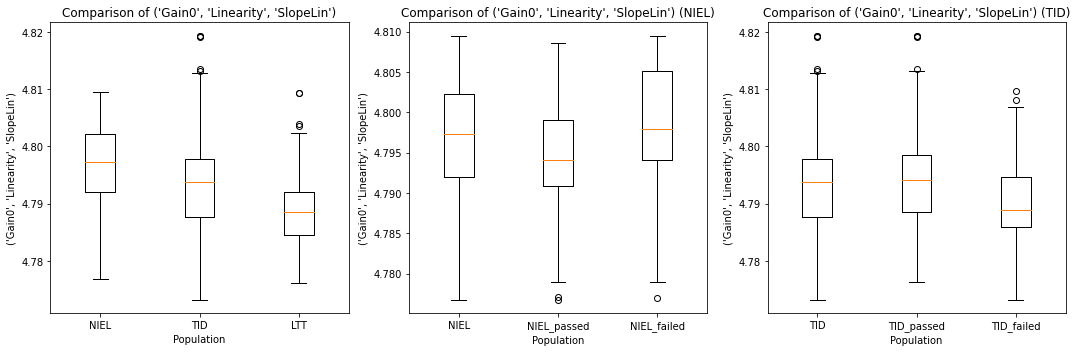

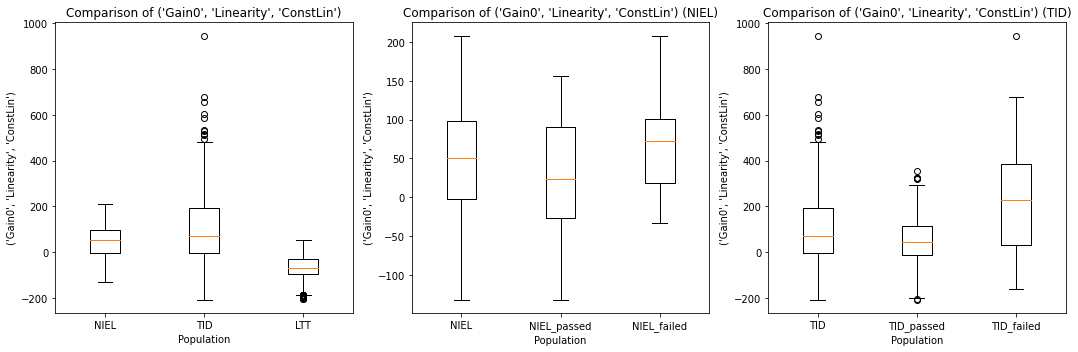

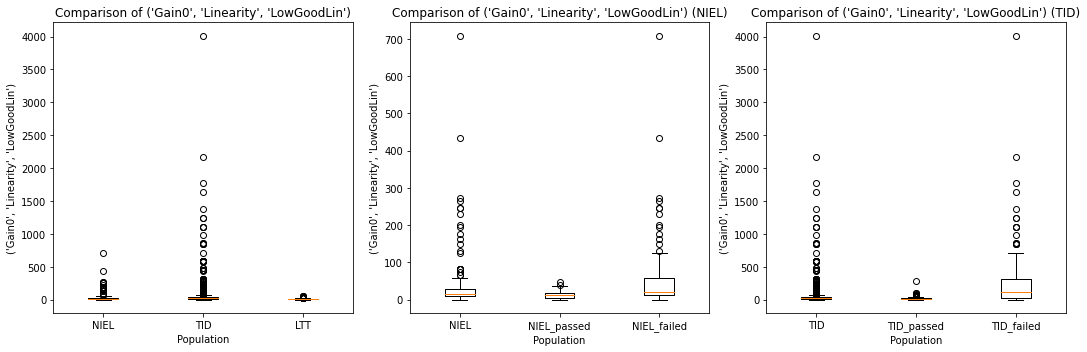

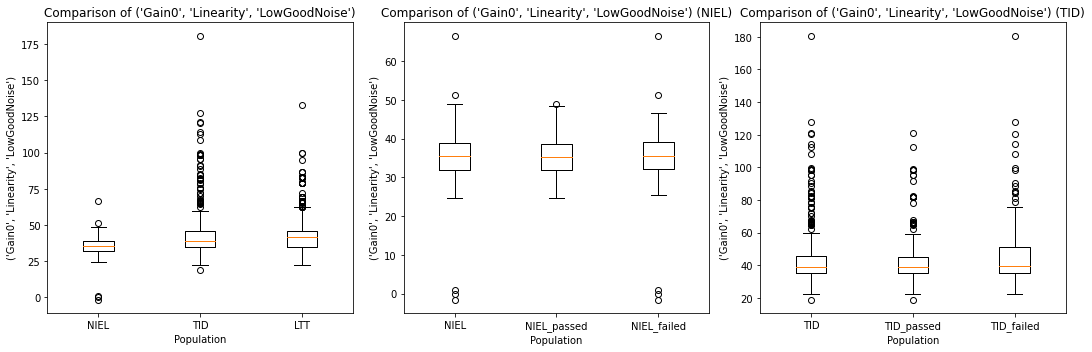

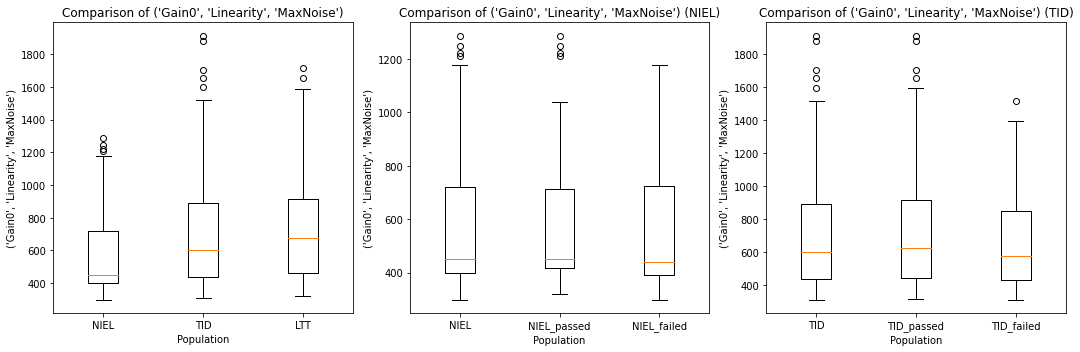

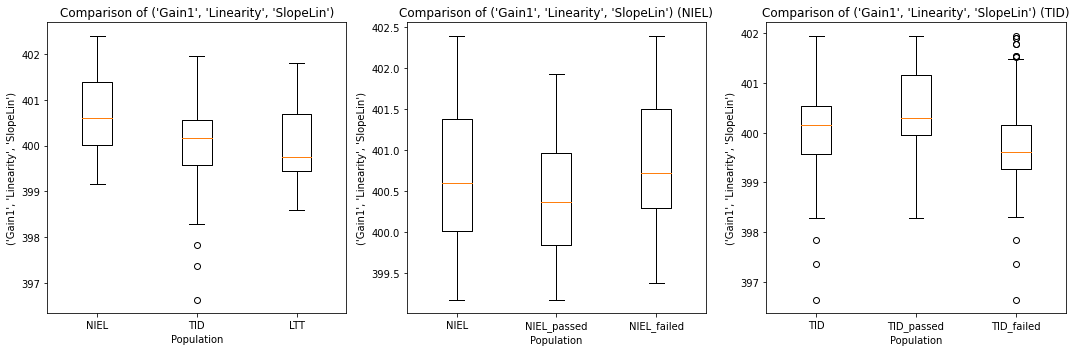

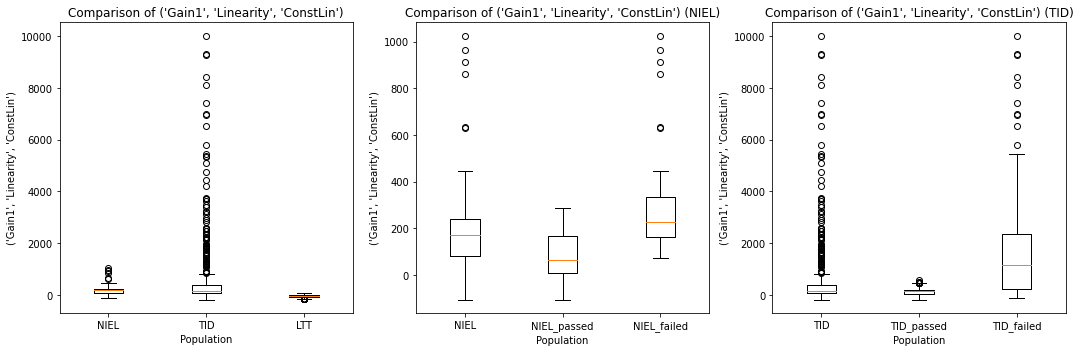

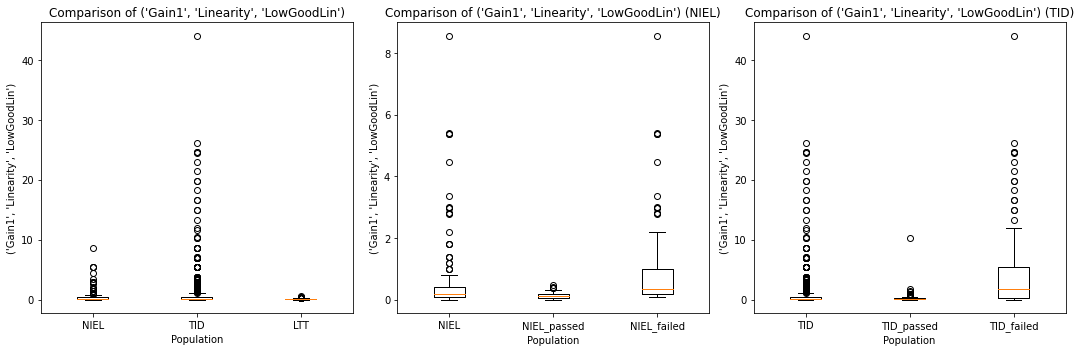

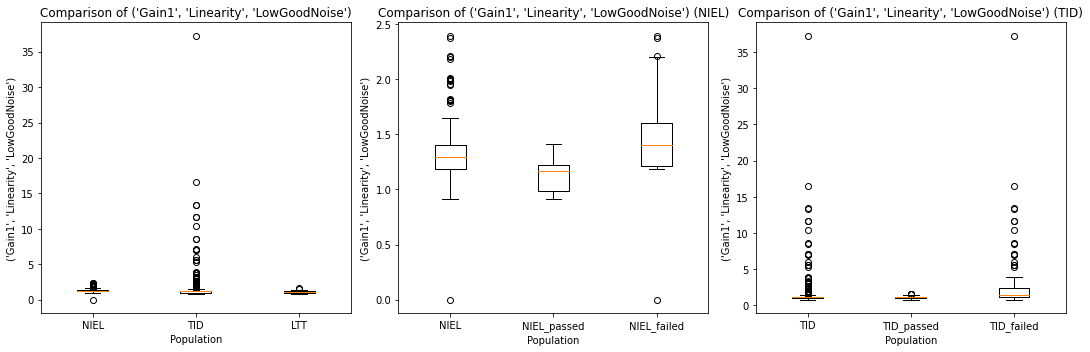

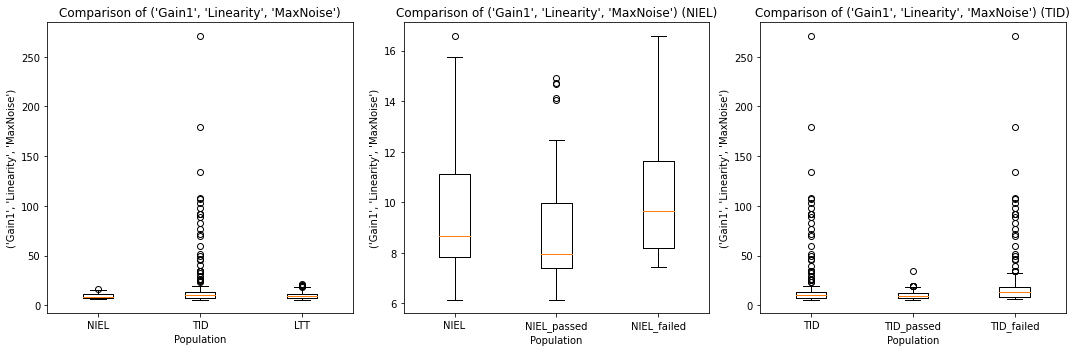

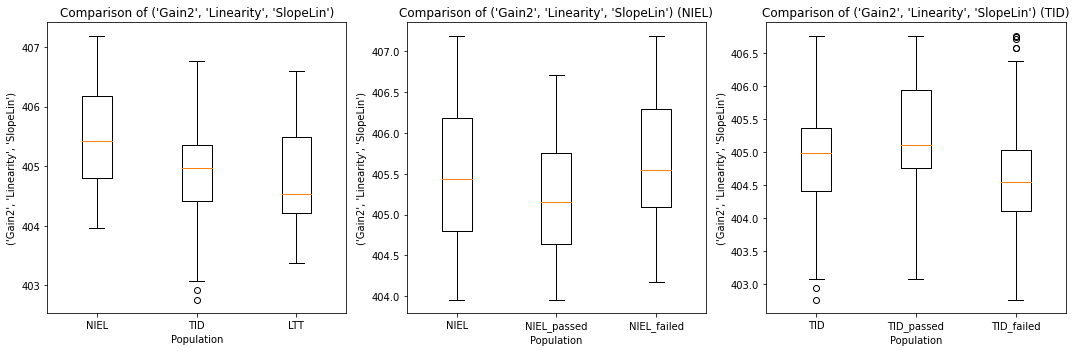

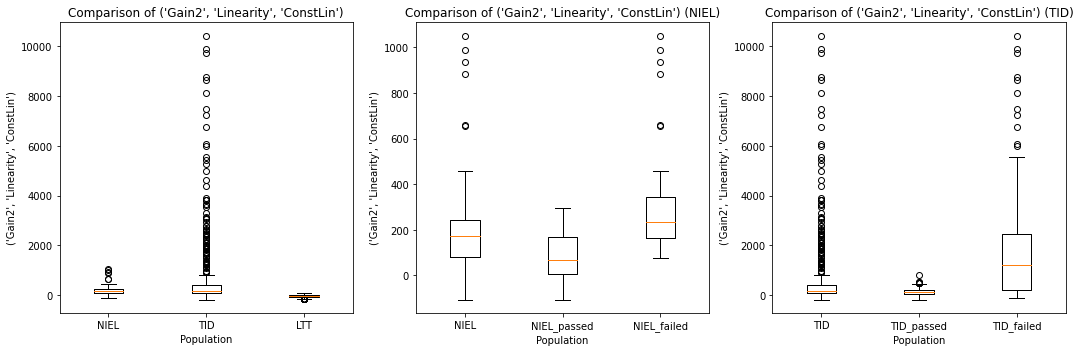

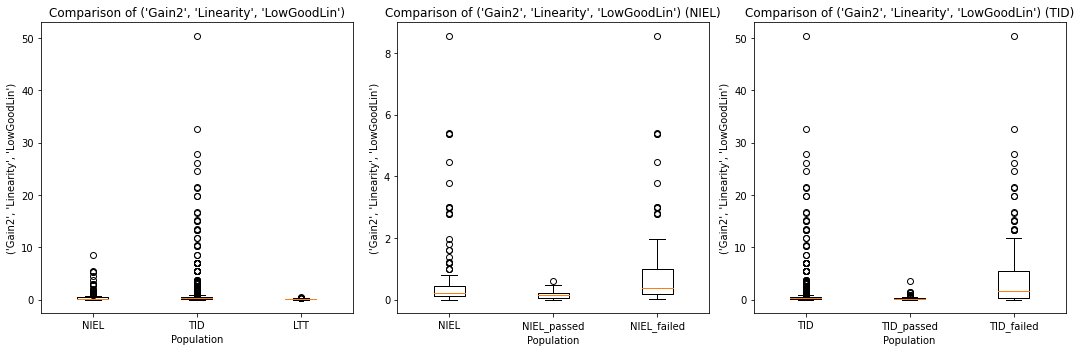

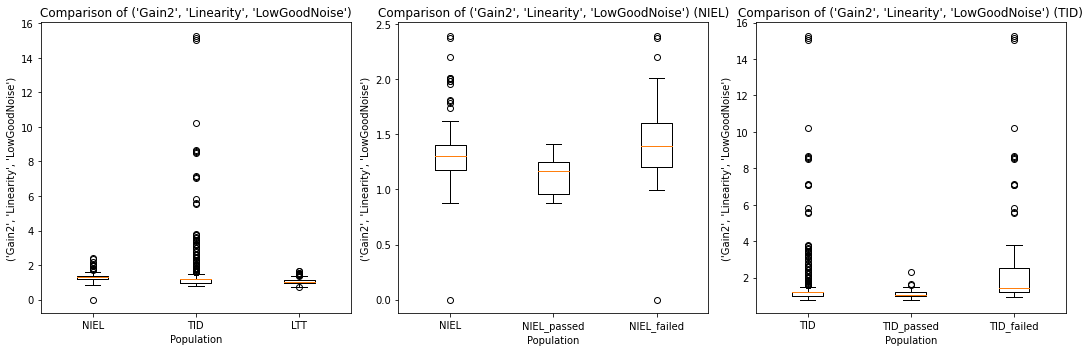

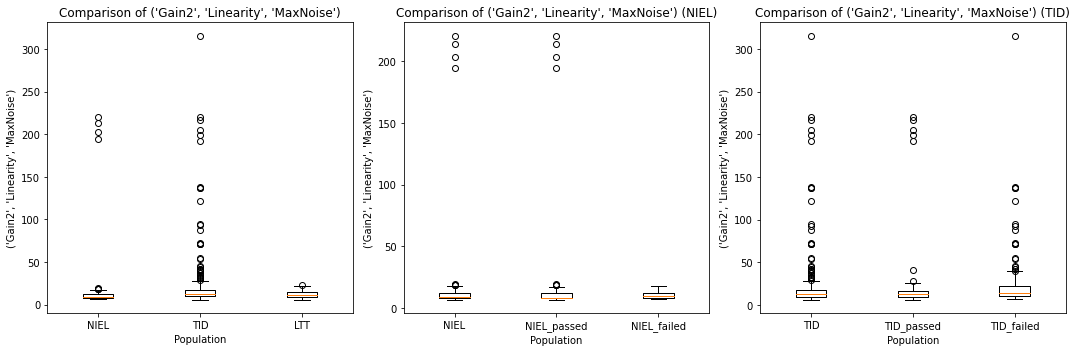

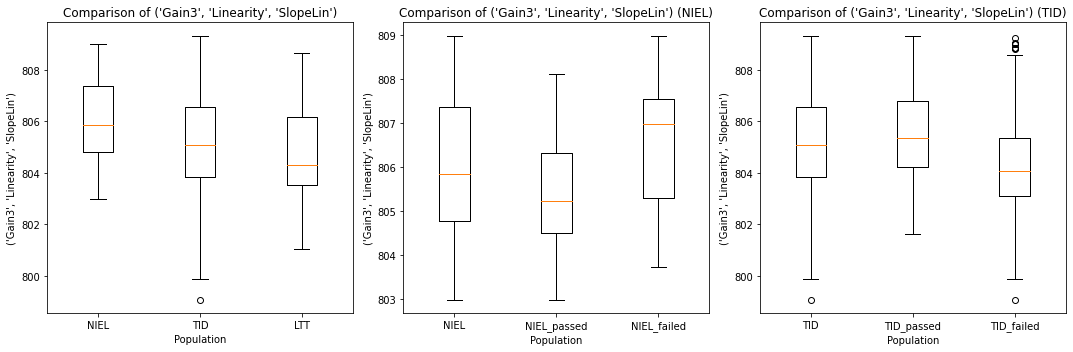

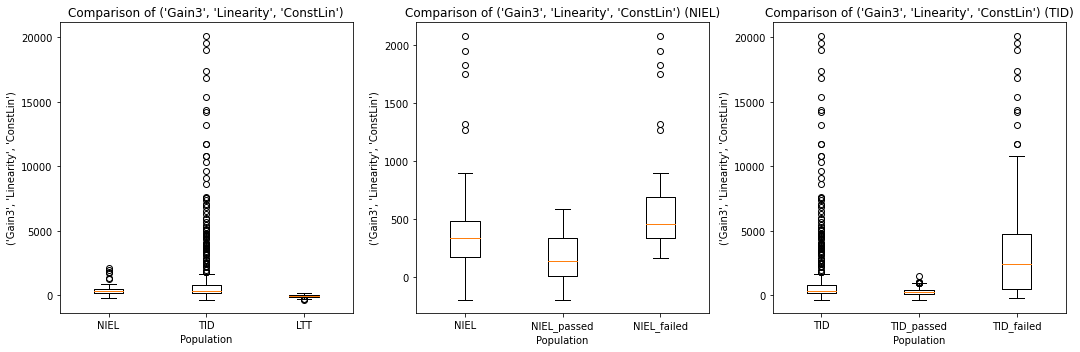

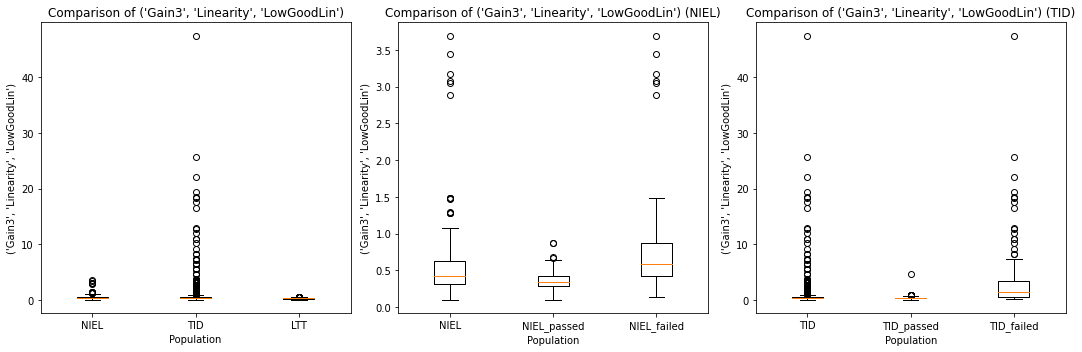

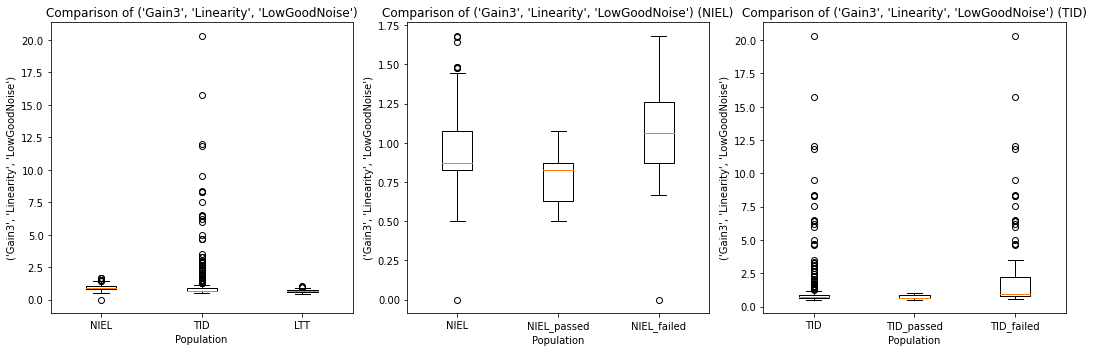

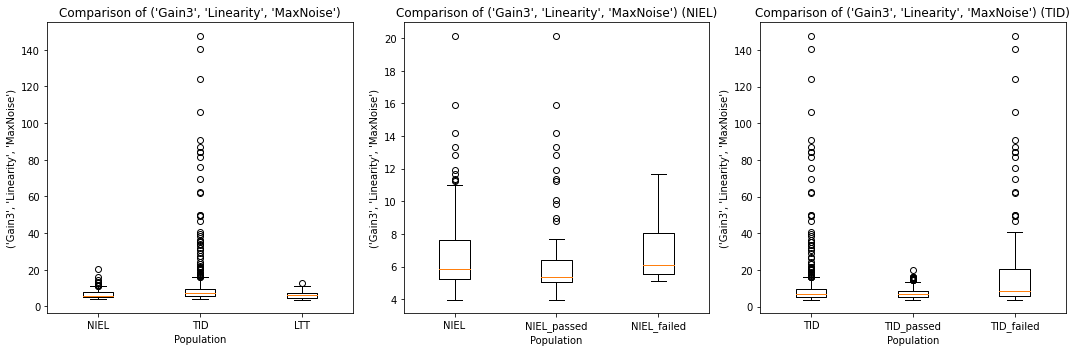

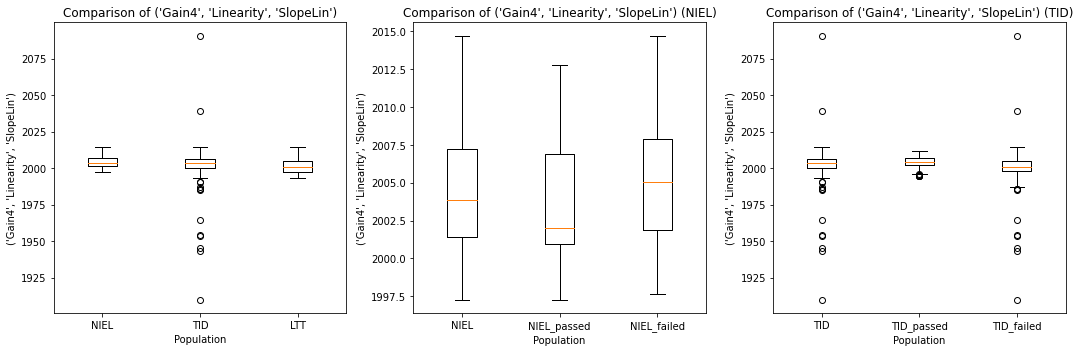

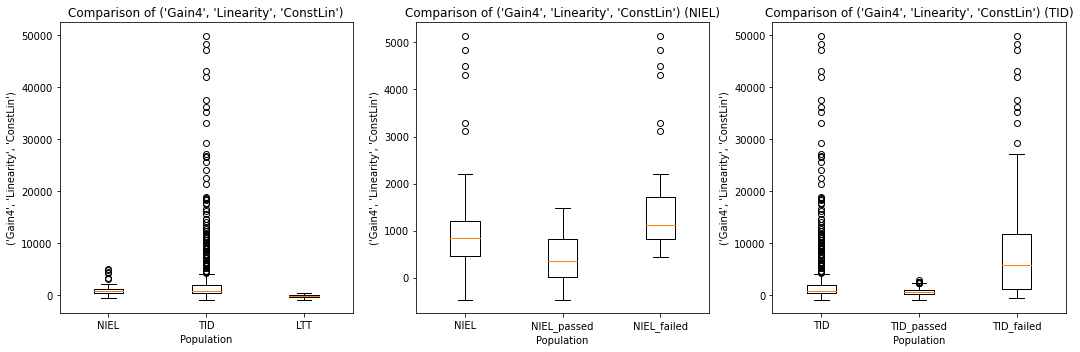

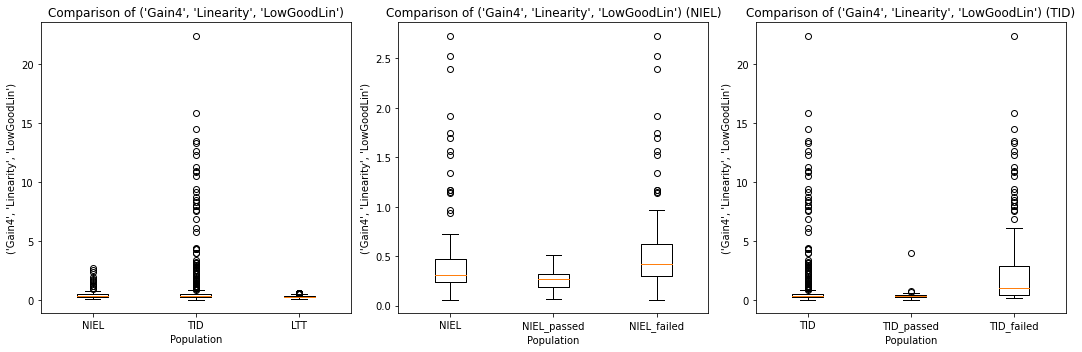

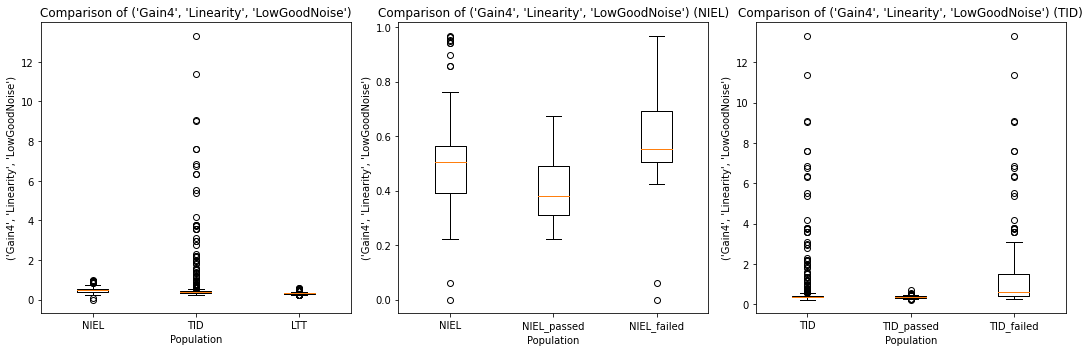

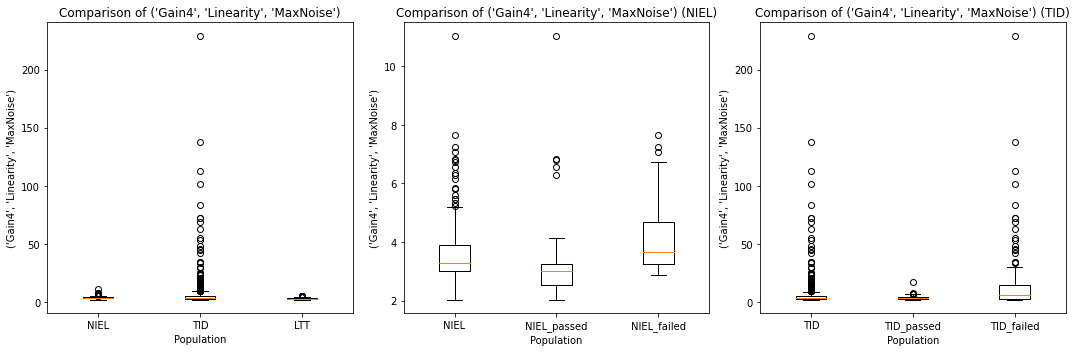

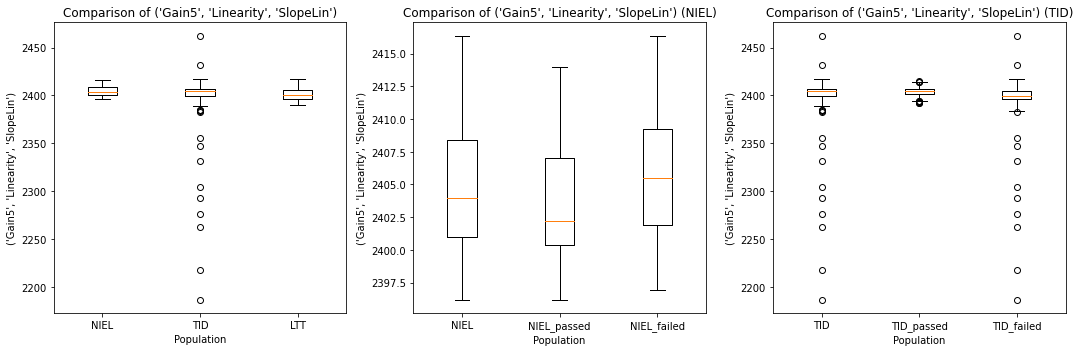

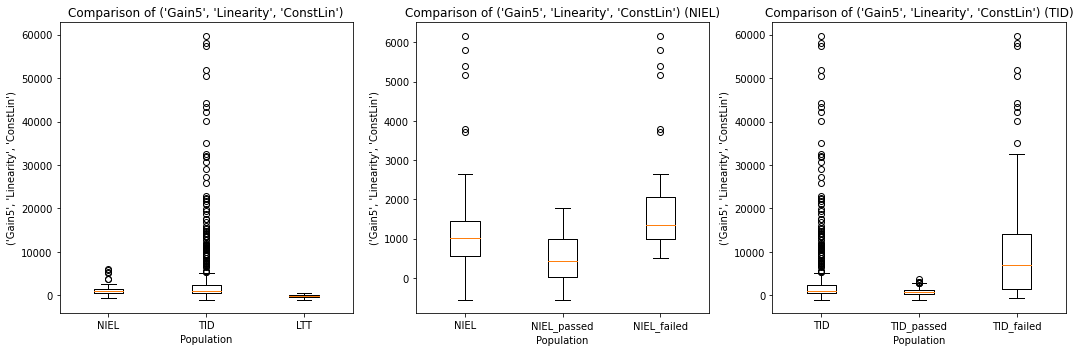

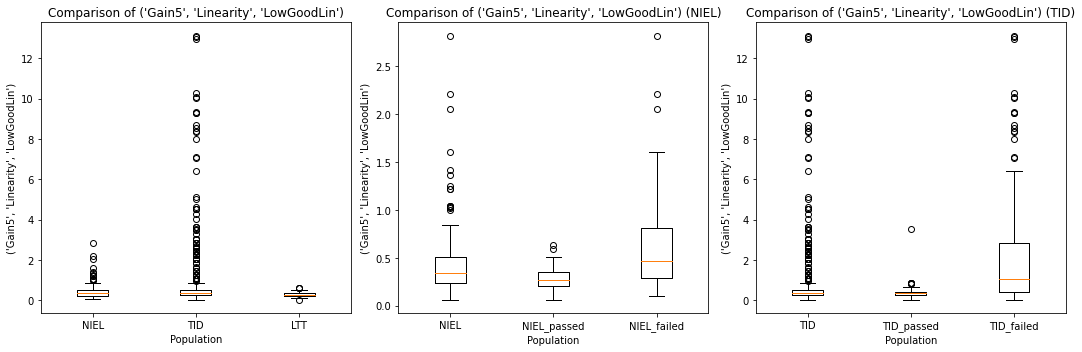

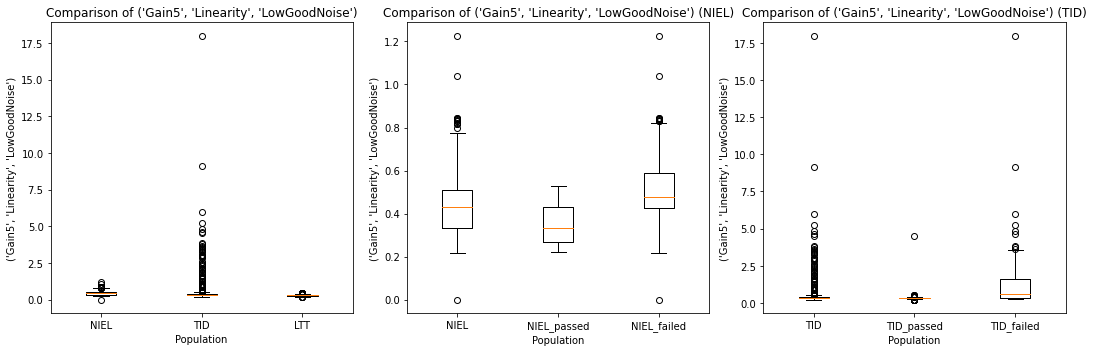

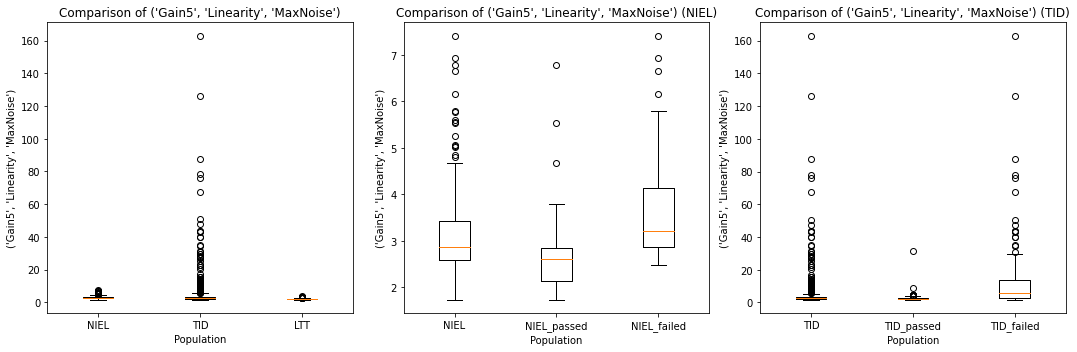

In [17]:
import matplotlib.pyplot as plt

# Create a list of the three populations
all_populations = [NIEL, TID, LTT]

NIEL_populations = [NIEL, NIEL_passed, NIEL_failed]

TID_populations = [TID, TID_passed, TID_failed]

# Create a list of labels for the x-axis
labelsAll = ['NIEL', 'TID', 'LTT']

labelsNiel = ['NIEL', 'NIEL_passed', 'NIEL_failed']

labelsTID = ['TID', 'TID_passed', 'TID_failed']

# Iterate over each feature and create a box plot for each
for feature in Slow2_filtred.columns:
    # Create a figure and axis for each feature
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Create a list of data for each population
    data_all = [population[feature] for population in all_populations]
    data_NIEL = [population[feature] for population in NIEL_populations]
    data_TID = [population[feature] for population in TID_populations]
    
    # Create the box plots for all populations
    ax1.boxplot(data_all)
    ax1.set_xticklabels(labelsAll)
    ax1.set_title(f'Comparison of {feature}')
    ax1.set_xlabel('Population')
    ax1.set_ylabel(f'{feature}')
    
    # Create the box plots for NIEL populations
    ax2.boxplot(data_NIEL)
    ax2.set_xticks([1, 2, 3])  # Set the tick positions directly
    ax2.set_xticklabels(labelsNiel)  # Set the tick labels for NIEL populations
    ax2.set_title(f'Comparison of {feature} (NIEL)')
    ax2.set_xlabel('Population')
    ax2.set_ylabel(f'{feature}')
    
    # Create the box plots for TID populations
    ax3.boxplot(data_TID)
    ax3.set_xticks([1, 2, 3])  # Set the tick positions directly
    ax3.set_xticklabels(labelsTID)  # Set the tick labels for TID populations
    ax3.set_title(f'Comparison of {feature} (TID)')
    ax3.set_xlabel('Population')
    ax3.set_ylabel(f'{feature}')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Display the plot
    plt.show()



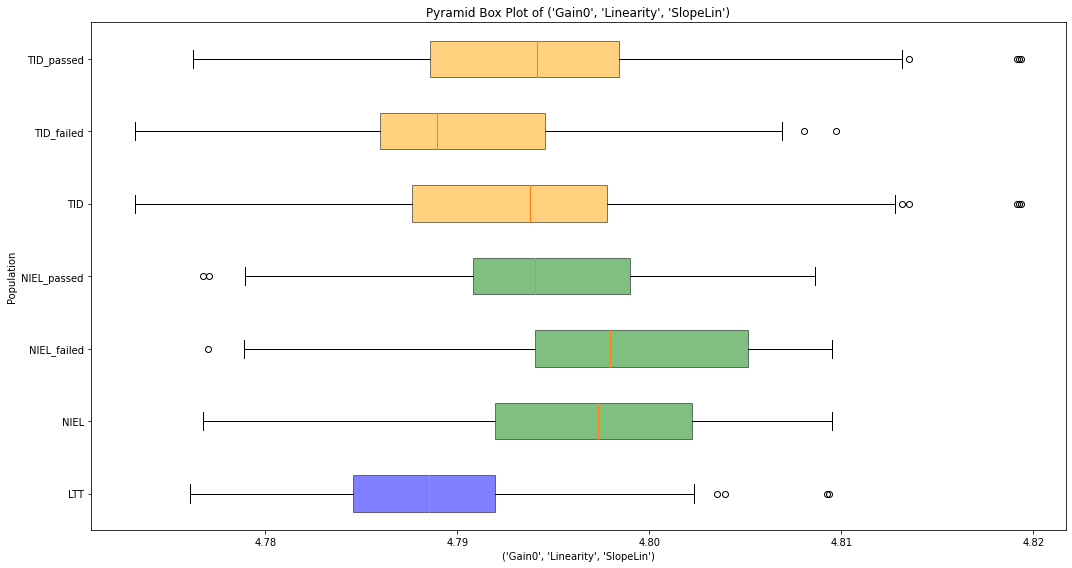

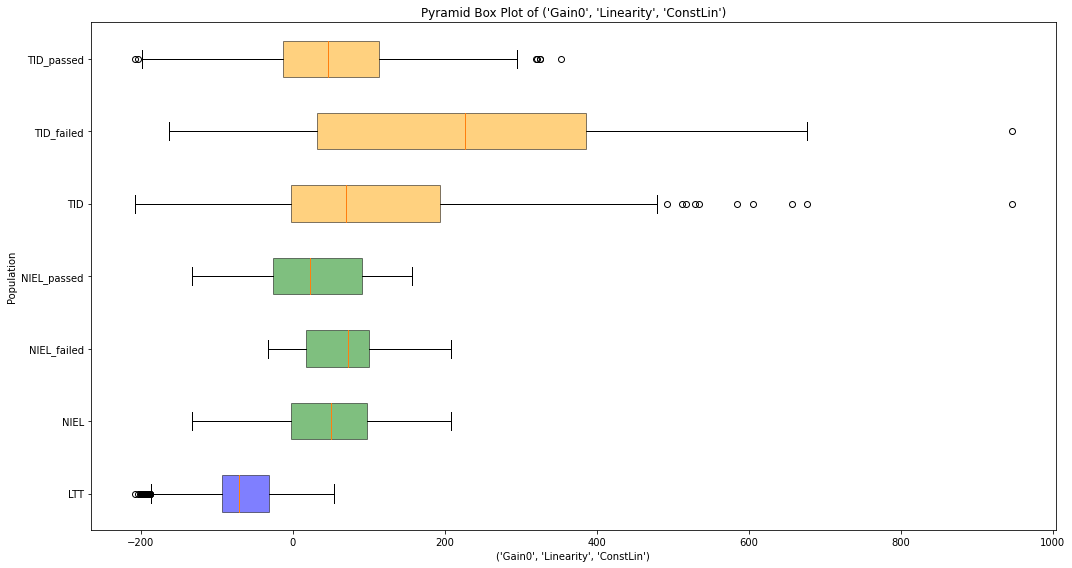

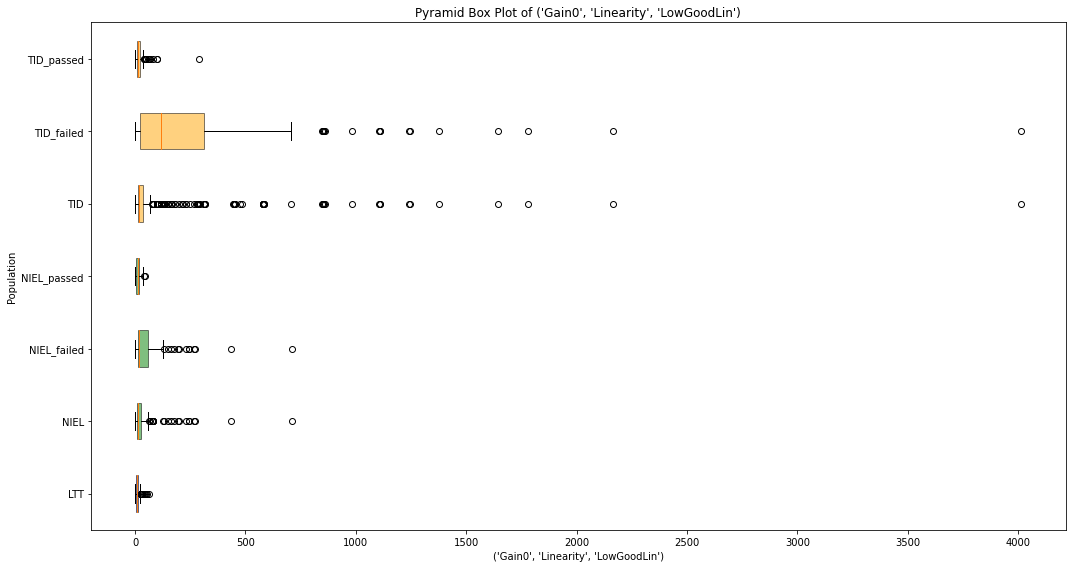

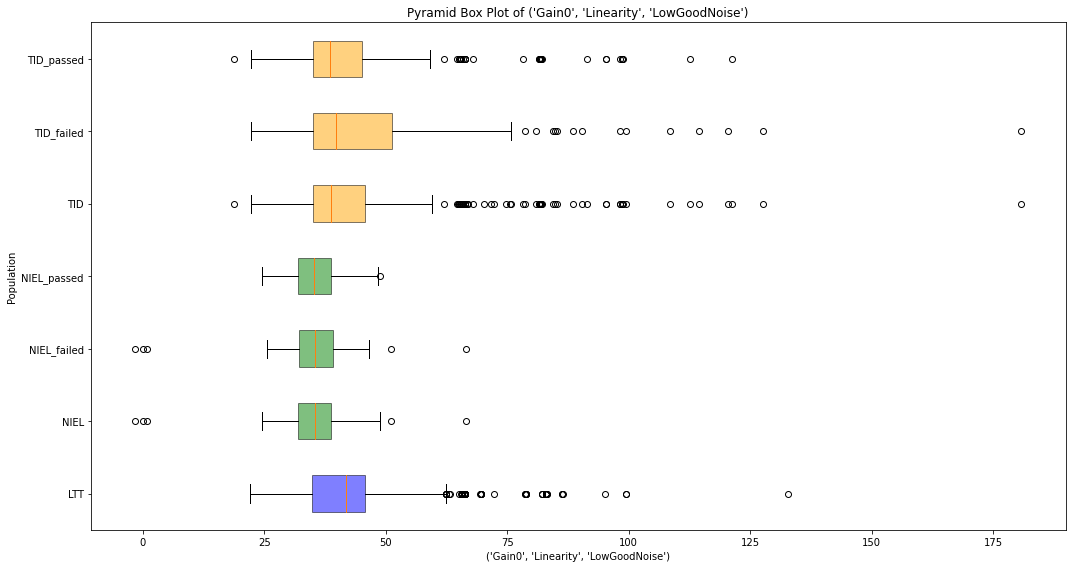

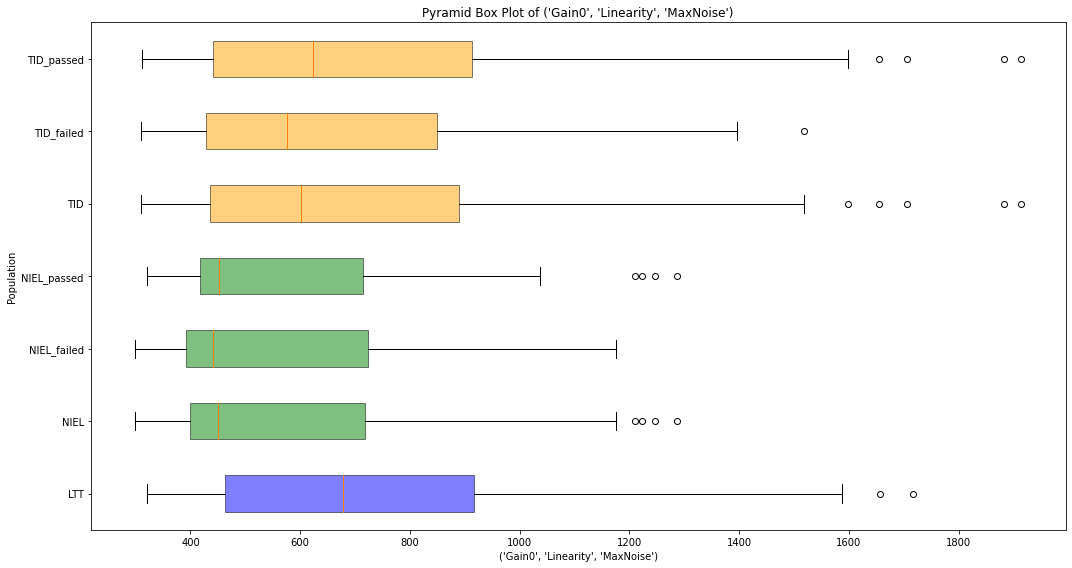

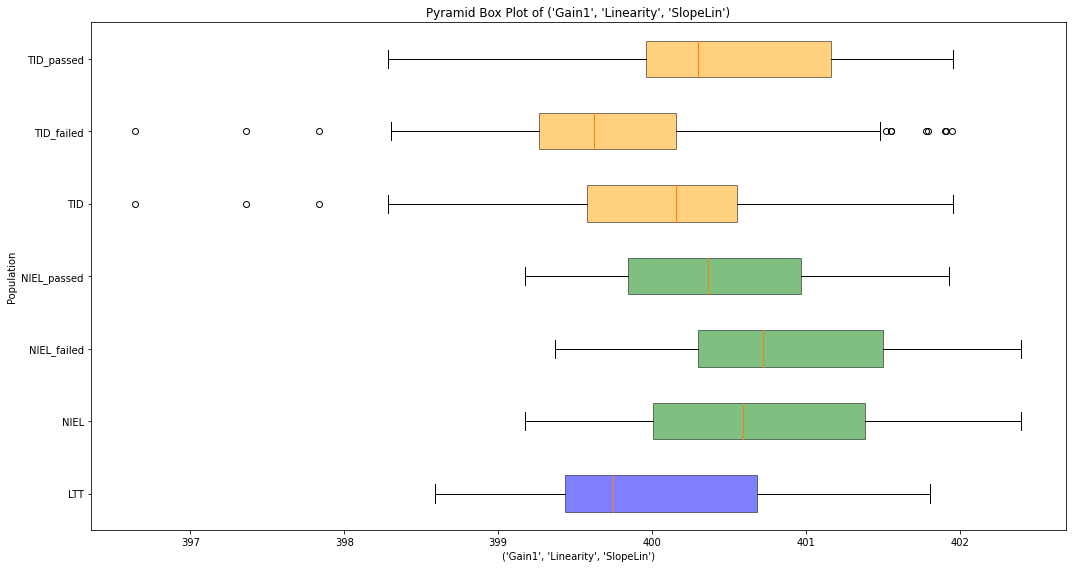

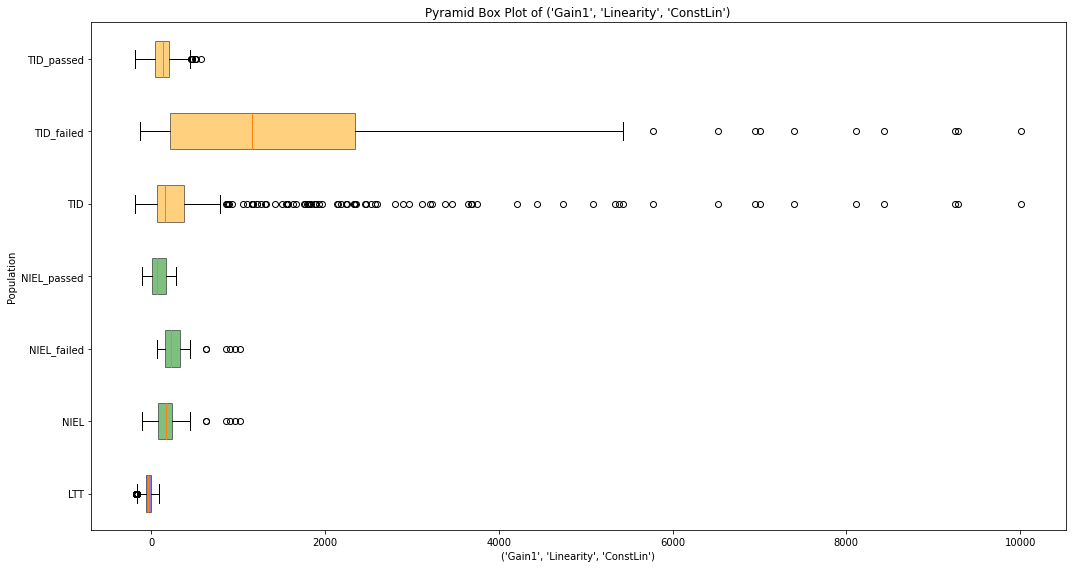

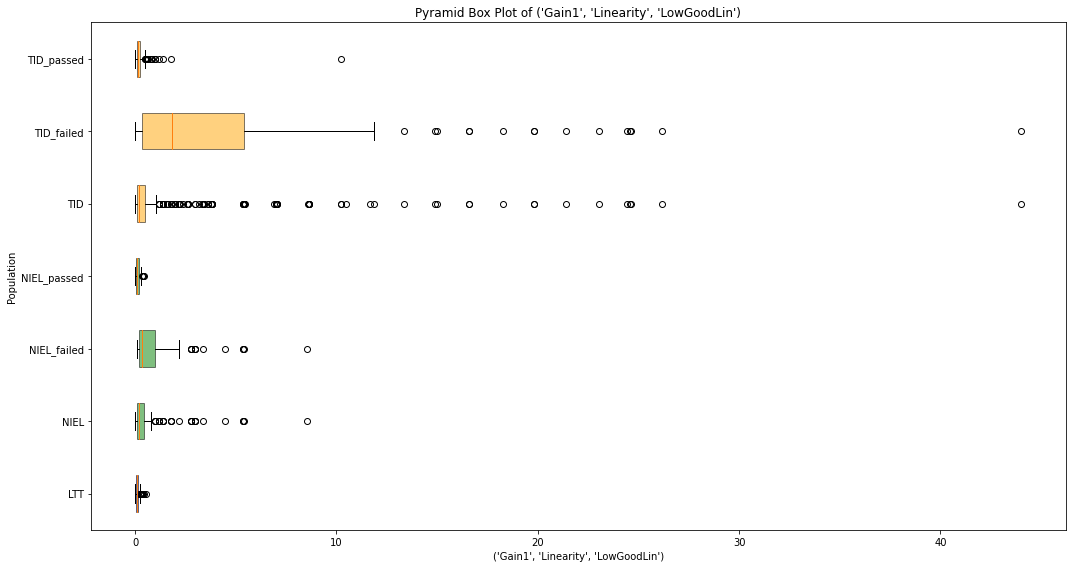

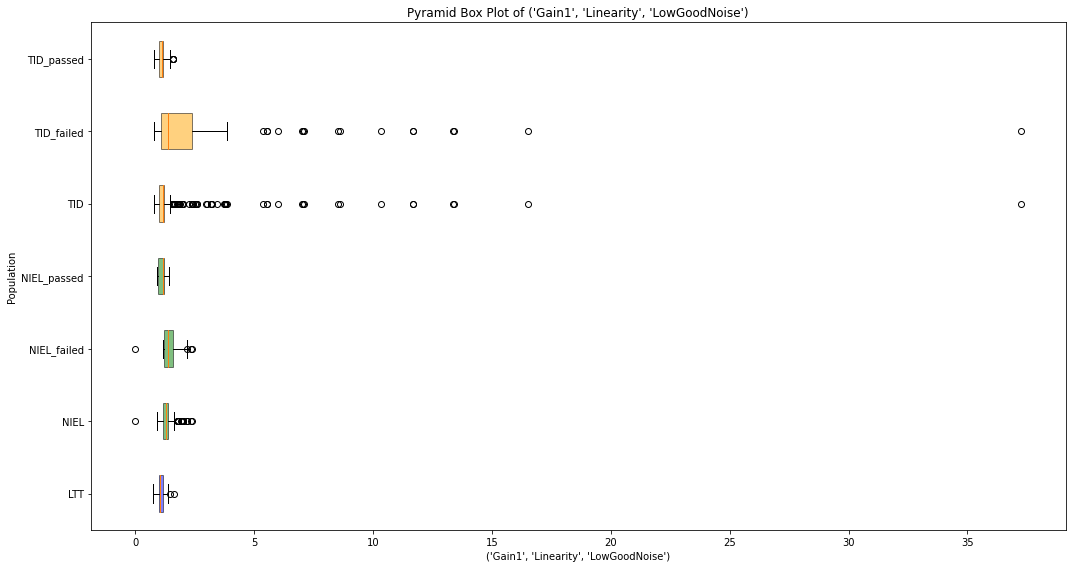

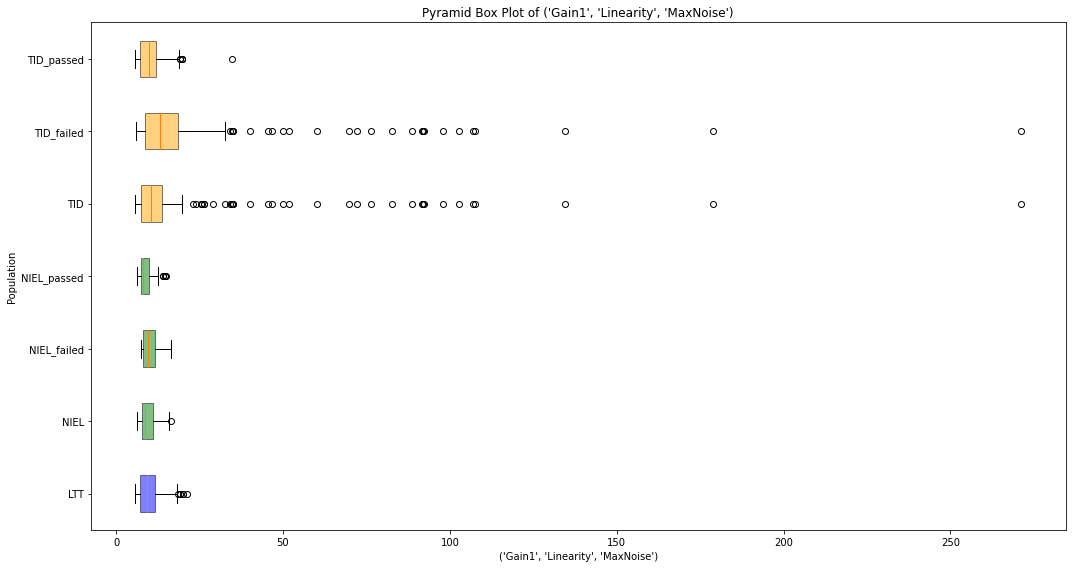

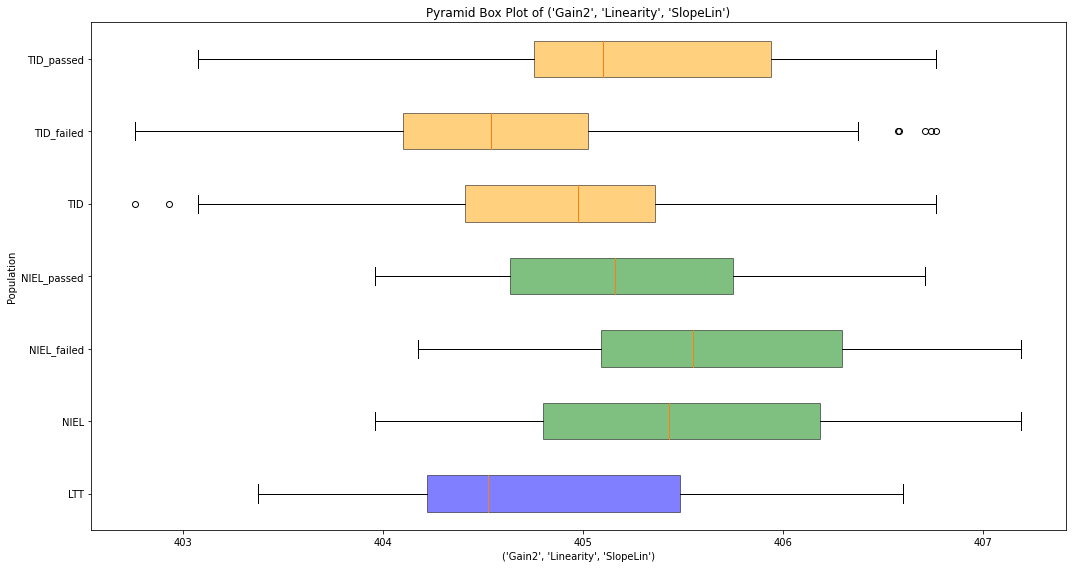

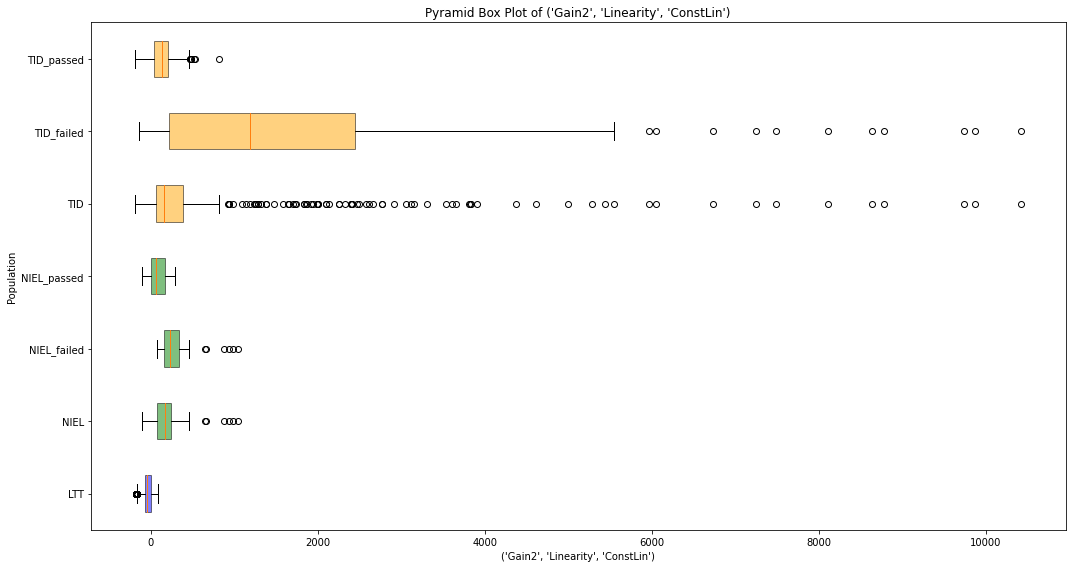

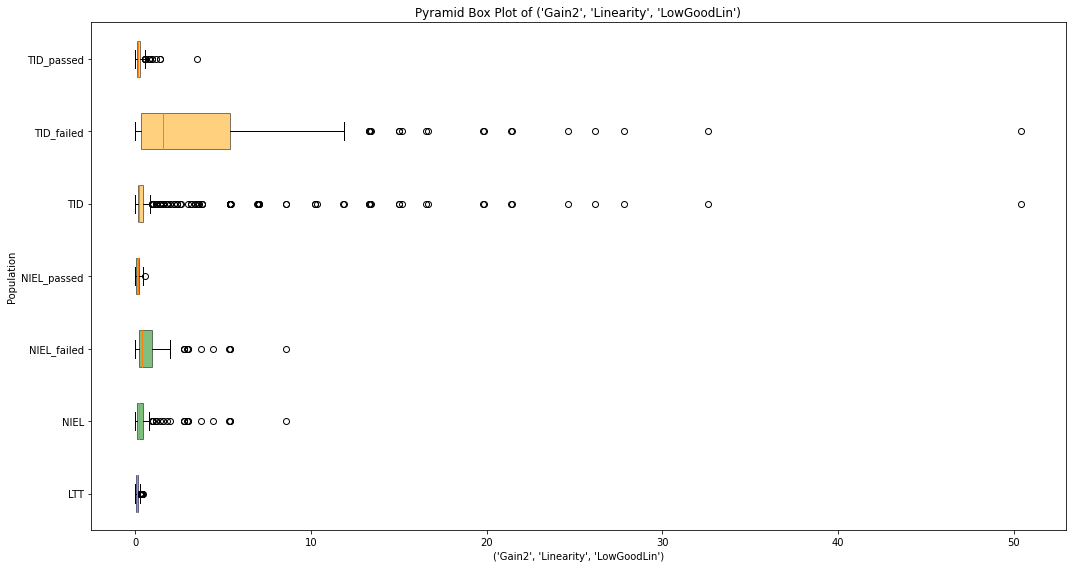

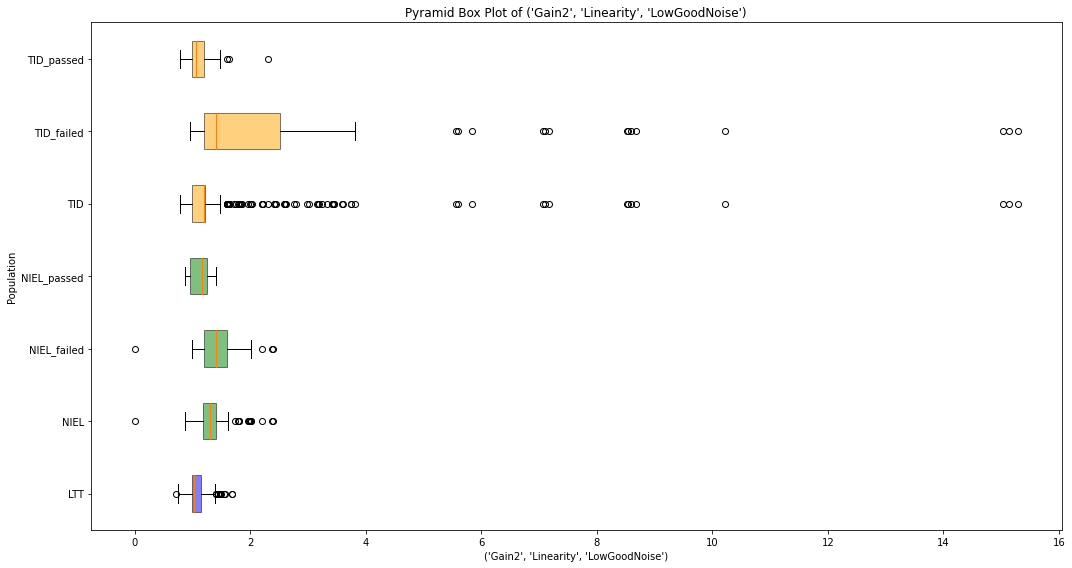

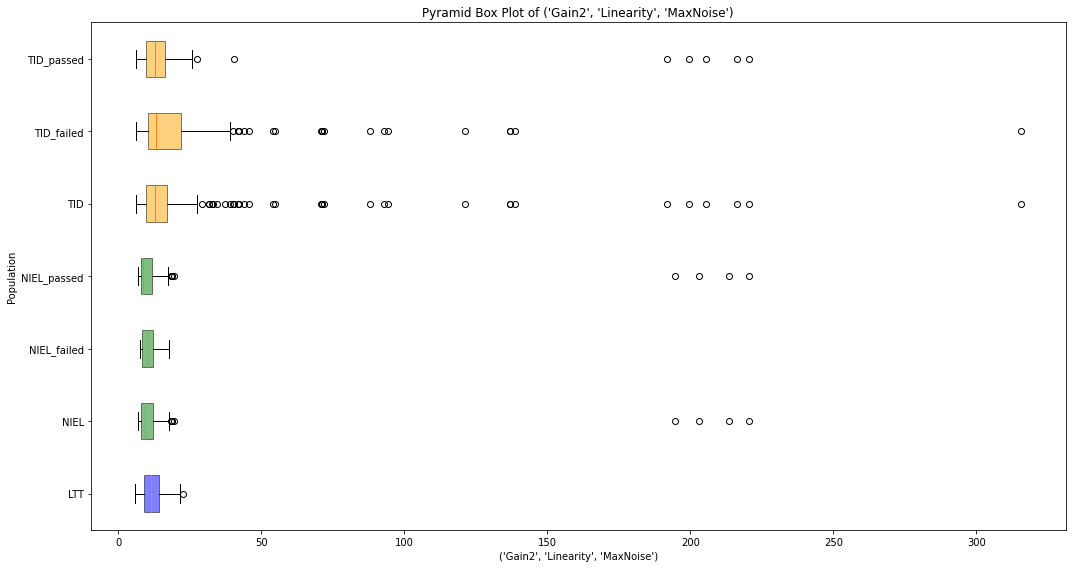

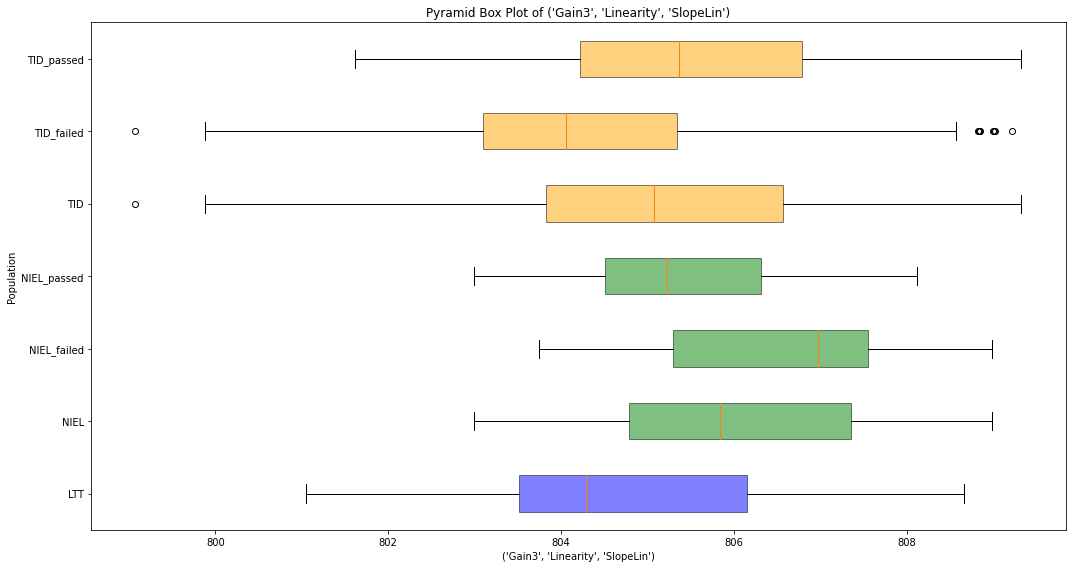

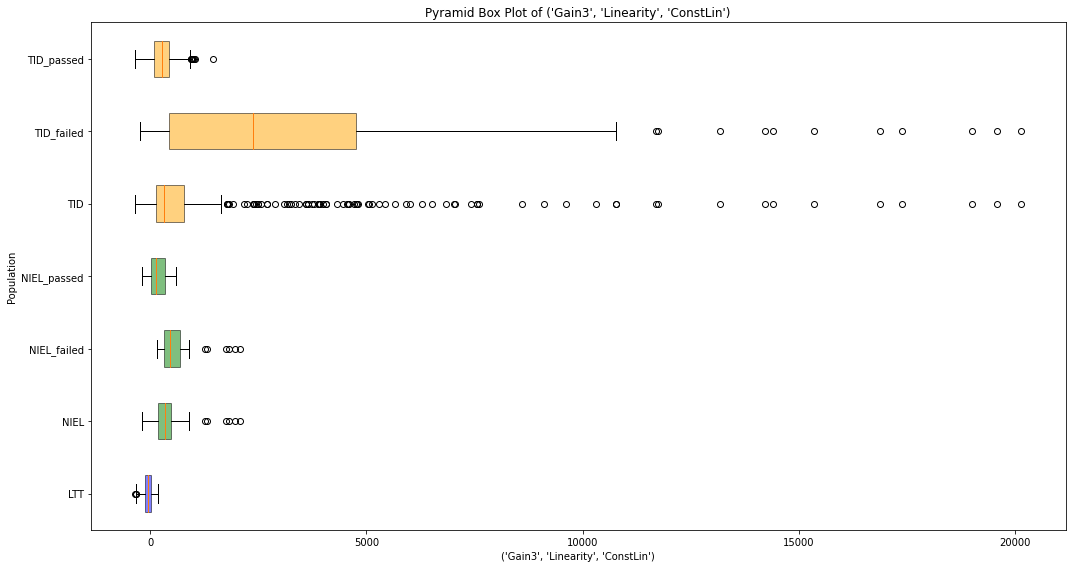

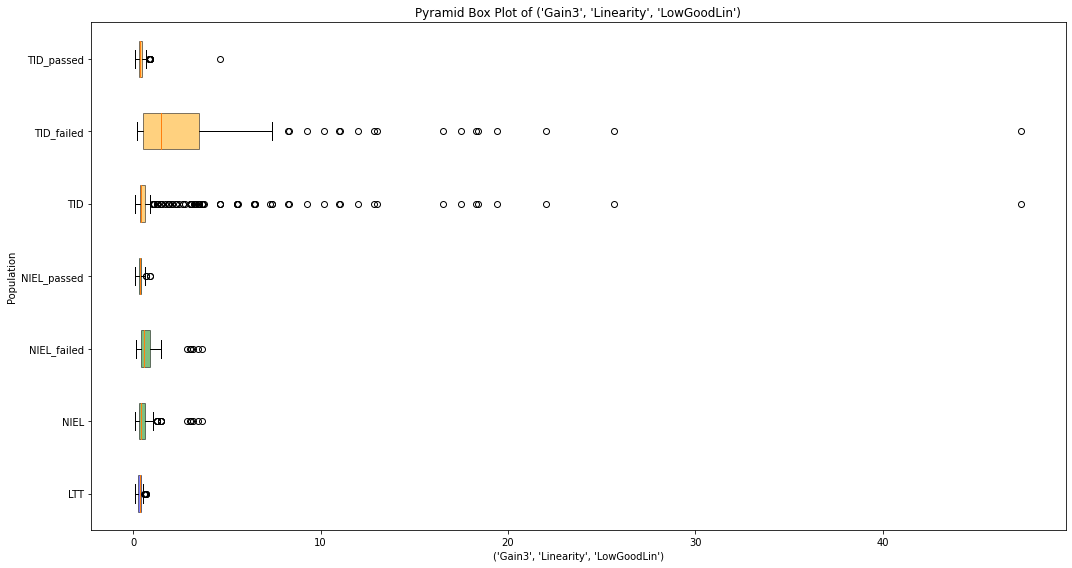

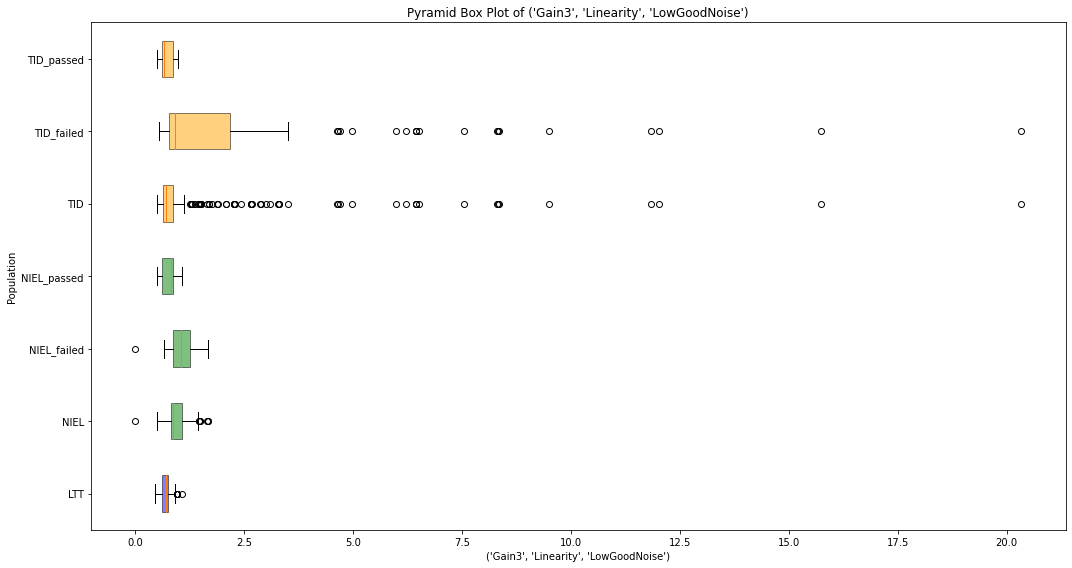

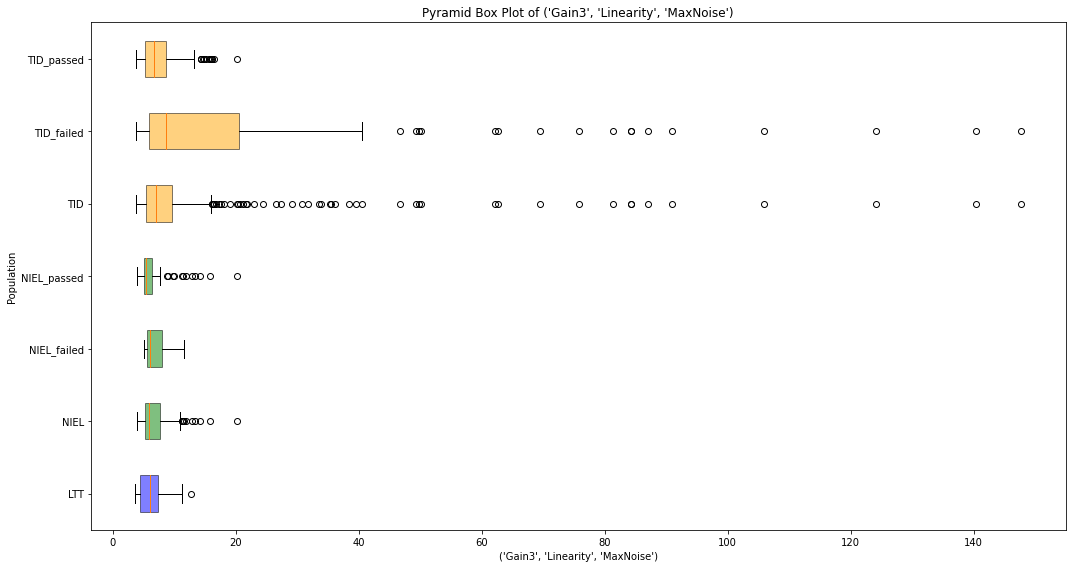

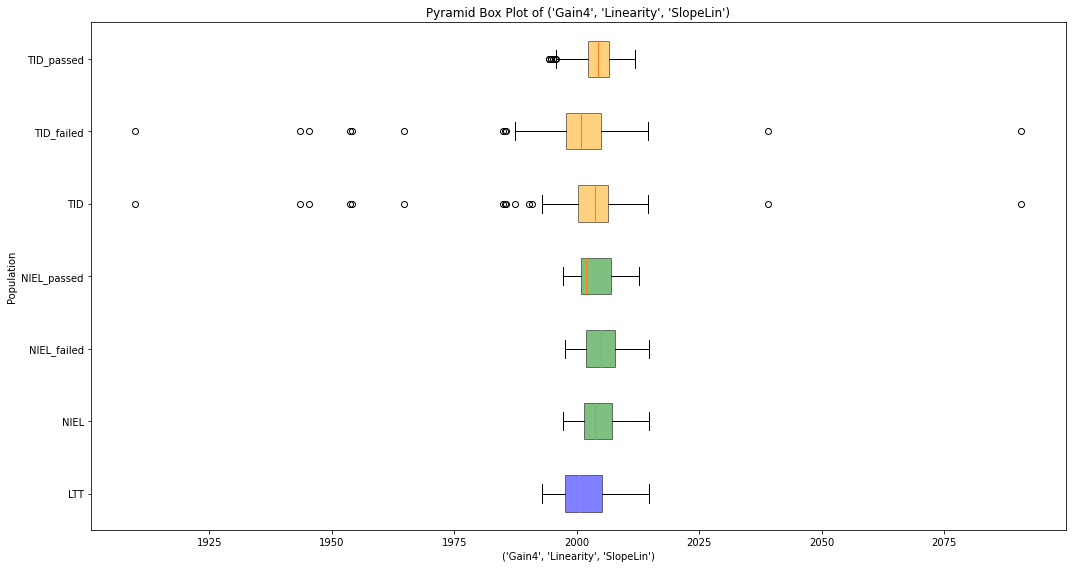

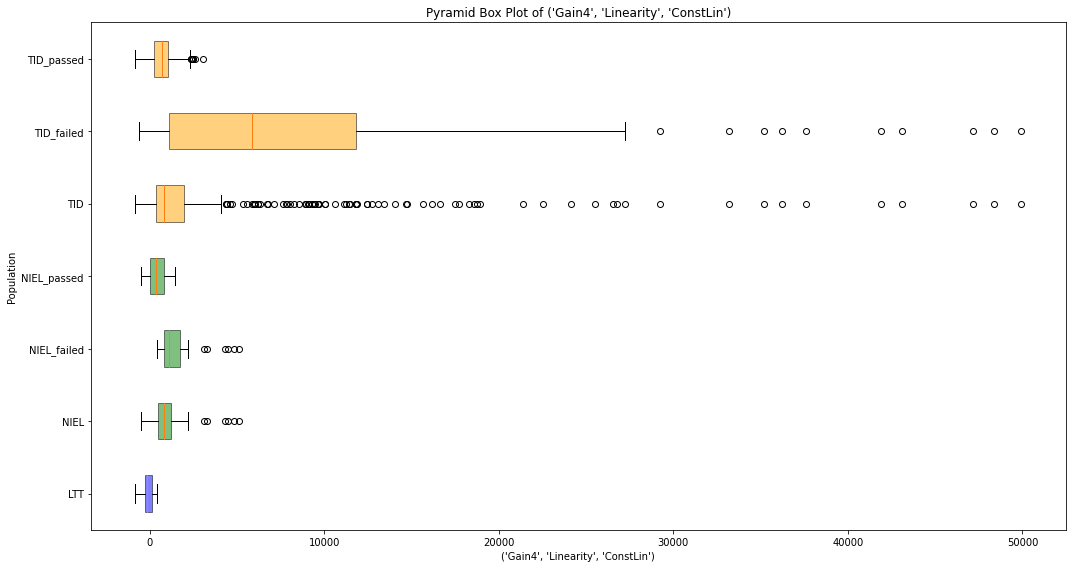

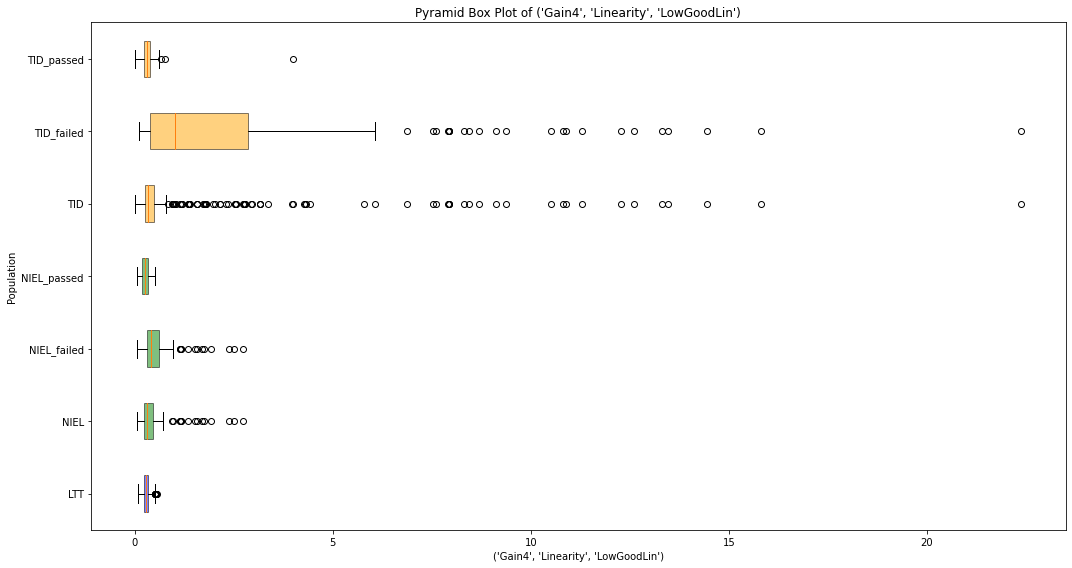

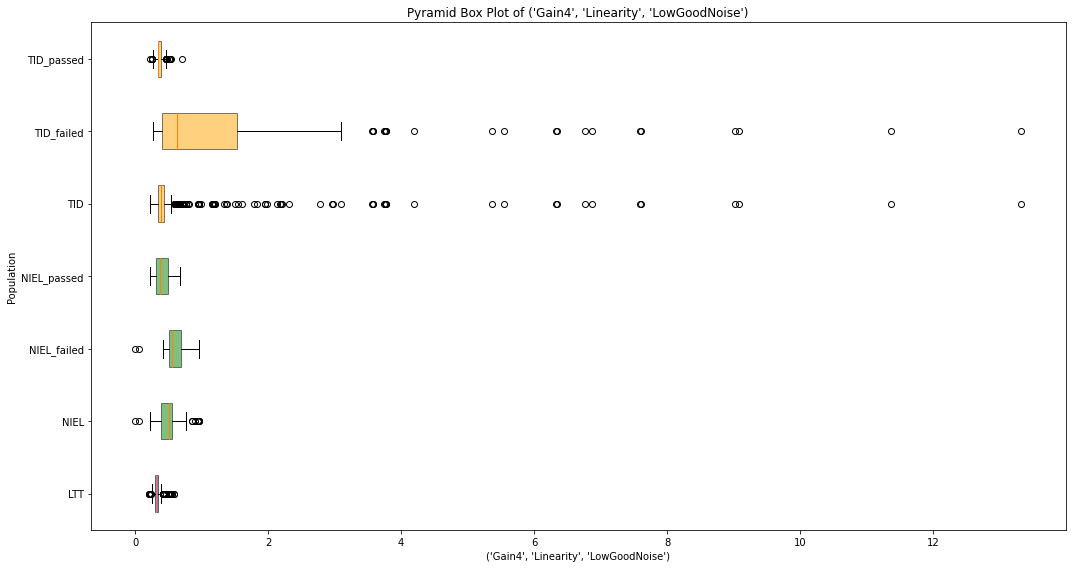

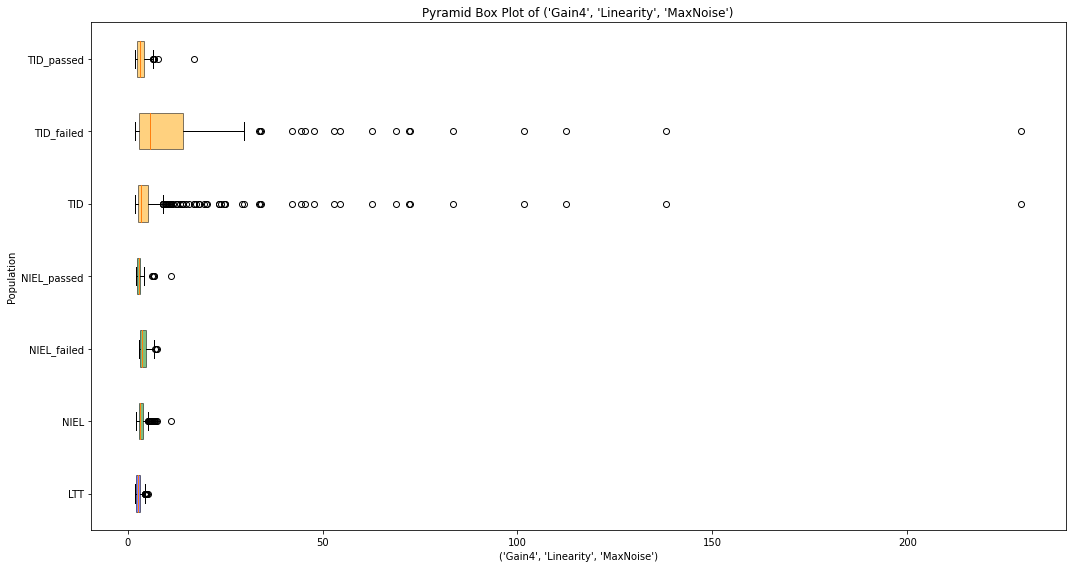

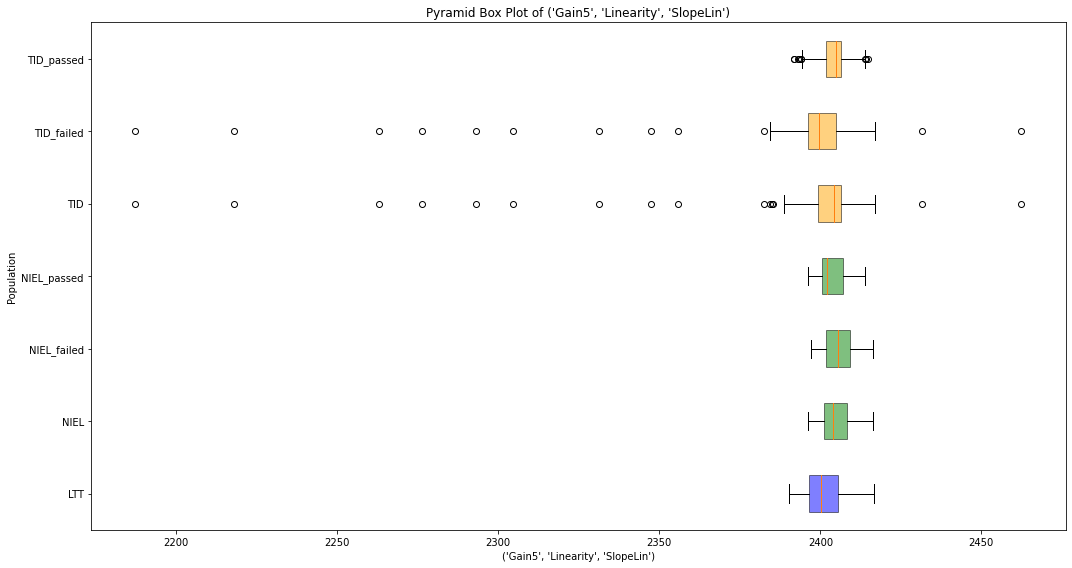

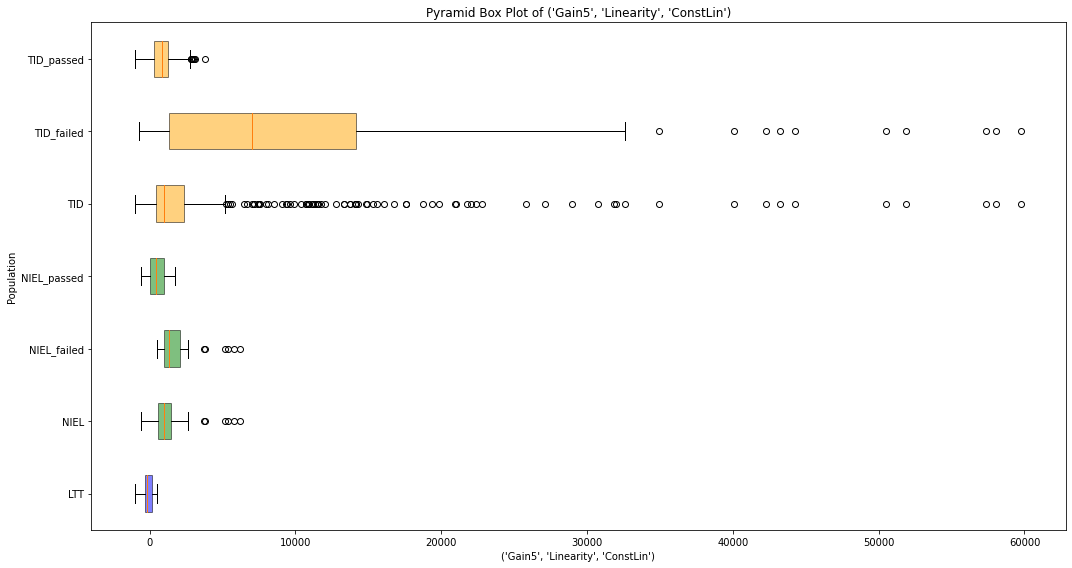

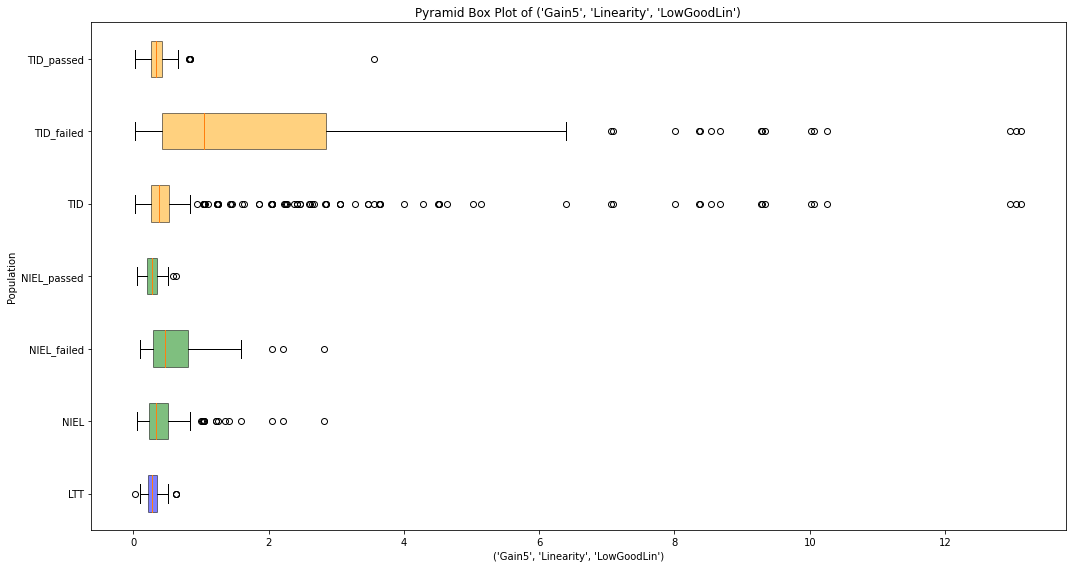

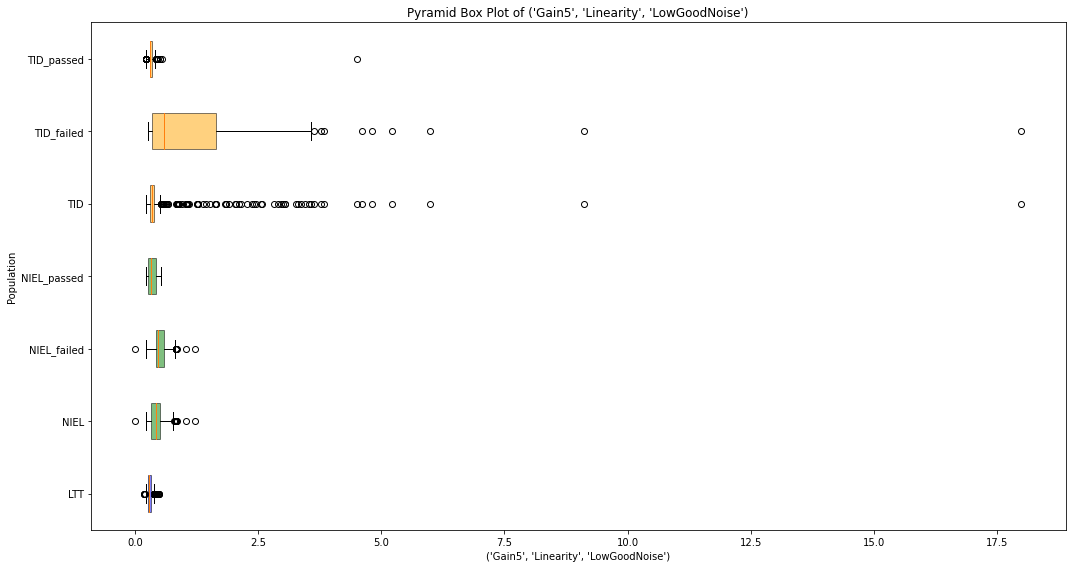

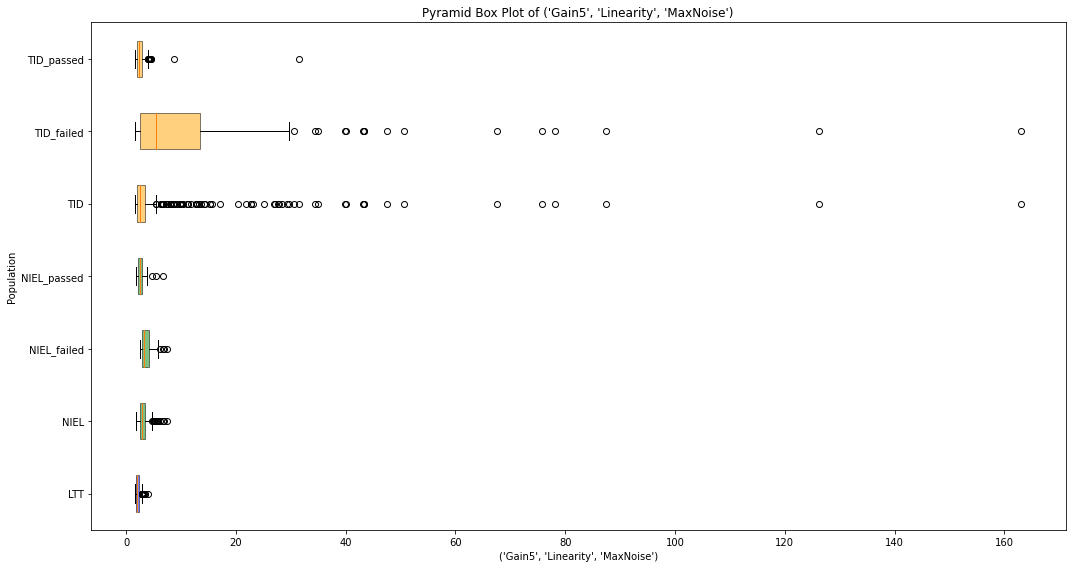

In [18]:
import matplotlib.pyplot as plt

# Create a list of the populations
populations = [LTT, NIEL, NIEL_failed, NIEL_passed, TID, TID_failed, TID_passed]

# Create a list of labels for the y-axis
labels = ['LTT', 'NIEL', 'NIEL_failed', 'NIEL_passed', 'TID', 'TID_failed', 'TID_passed']

# Create a list of colors for the boxes
colors = ['blue', 'green', 'green', 'green', 'orange', 'orange', 'orange']

# Calculate the positions for the boxes
positions = list(range(1, len(populations) + 1))

# Iterate over each feature and create the pyramid box plot
for feature in Slow2_filtred.columns:
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15,8))
    
    # Create a list of data for each population
    data = [population[feature] for population in populations]
    
    # Create the box plot with custom colors
    boxes = ax.boxplot(data, vert=False, positions=positions, patch_artist=True)
    
    # Set the facecolor of each box
    for patch, color in zip(boxes['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5) 
    # Set the y-axis labels
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    
    # Set the title and labels for the plot
    ax.set_title(f'Pyramid Box Plot of {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Population')
    
    # Adjust the spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()


In [19]:
custom_filter = [('Checkbox',dict(radio_categories=[dict(name = 'LTT',indexes=['LTT']),
                                dict(name = 'NIEL',indexes=['NIEL']),
                                dict(name = 'NIEL_passed',indexes=['NIEL_passed']),
                                dict(name = 'NIEL_failed',indexes=['NIEL_failed']),
                                dict(name = 'TID',indexes=['TID']),
                                dict(name = 'TID_passed',indexes=['TID_passed']),
                                dict(name = 'TID_failed',indexes=['TID_failed']),
                                ])),('Slider')]



for progress,feature in enumerate(allpopulations.columns[:-2]):
    plot = FATL.FenBokehGrapher(allpopulations['Population_id'],allpopulations[feature],
                                FENICS2.Board.id.iloc[allpopulations.index],
                                allpopulations['Population'],
                                colors=FENICS2.Board.burnTime.iloc[allpopulations.index],labels=allpopulations['Population'],tooltips=[("FENICS","@id"),("Population","@Population")])
    plot.plotter(plotType='histogram',filters=custom_filter,title=f'{feature}',showGraph=False)
    plot.save_as_html(path='/users/divers/atlas/sisaid/home2/fen2_output_comparaison/jitter/',filename=f'{feature}_dataSpread')
    FATL.loadingBar(progress,len(allpopulations.columns[:-2]),suffix=str(feature))


|                                                  | progress: 100%                                                                                   DONE 
